In [1]:
# ---
# ### **Part 0: Setup and Imports**
# ---

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn import preprocessing
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set a consistent style for our plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Define key paths
DATASET_PATH = "Data/genres_original"
FEATURES_CSV_PATH = "Data/features_30_sec.csv"
METADATA_PATH = "gtzan_metadata.csv"

In [2]:
# ---
# ### **Part 1: Initial Data Loading & Metadata Analysis**
# ---

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from tqdm import tqdm

def build_metadata_robust(dataset_path):
    """
    Scans the GTZAN directory and extracts metadata from each .wav file.
    This version includes a try-except block to handle potential file loading errors.
    """
    metadata_list = []
    # Ensure genres are processed in a consistent order
    genres = sorted([g for g in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, g))])
    
    print("Building robust metadata file...")
    for genre in tqdm(genres, desc="Processing genres"):
        genre_path = os.path.join(dataset_path, genre)
        for filename in sorted(os.listdir(genre_path)):
            if filename.endswith('.wav'):
                filepath = os.path.join(genre_path, filename)
                try:
                    # Attempt to load audio file to verify it's not corrupt and get info
                    y, sr = librosa.load(filepath, sr=None, duration=1) # Load only 1 sec to be fast
                    duration = librosa.get_duration(path=filepath)
                    
                    metadata_list.append({
                        'filename': filename,
                        # Standardize path separators for cross-platform compatibility
                        'filepath': filepath.replace('\\', '/'),
                        'genre': genre,
                        'duration': duration,
                        'sample_rate': sr
                    })
                except Exception as e:
                    # If a file is corrupted or unreadable, print a warning and skip it.
                    print(f"\nWARNING: Could not process {filepath}. Skipping file. Error: {e}")

    df = pd.DataFrame(metadata_list)
    return df

# --- Execution ---
# We only need to run the scan once.
if not os.path.exists(METADATA_PATH):
    metadata_df = build_metadata_robust(DATASET_PATH)
    if metadata_df.empty:
        raise ValueError("Metadata creation failed. No audio files were processed. Check DATASET_PATH.")
    metadata_df.to_csv(METADATA_PATH, index=False)
else:
    print(f"Loading existing metadata from {METADATA_PATH}")
    metadata_df = pd.read_csv(METADATA_PATH)

print("\n--- Dataset Metadata Analysis ---")
if not metadata_df.empty:
    print(f"Successfully loaded/created metadata for {len(metadata_df)} audio files.")
    print("\nFirst 5 rows of metadata:")
    print(metadata_df.head())

    print("\nDuration Statistics (in seconds):")
    print(metadata_df['duration'].describe())

    print("\nSample Rate Distribution:")
    print(metadata_df['sample_rate'].value_counts())
else:
    print("WARNING: Metadata DataFrame is empty. Subsequent cells may fail.")

Building robust metadata file...


Processing genres:  50%|█████     | 5/10 [00:06<00:05,  1.14s/it]

Processing genres: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


--- Dataset Metadata Analysis ---
Successfully loaded/created metadata for 999 audio files.

First 5 rows of metadata:
          filename                                    filepath  genre  \
0  blues.00000.wav  Data/genres_original/blues/blues.00000.wav  blues   
1  blues.00001.wav  Data/genres_original/blues/blues.00001.wav  blues   
2  blues.00002.wav  Data/genres_original/blues/blues.00002.wav  blues   
3  blues.00003.wav  Data/genres_original/blues/blues.00003.wav  blues   
4  blues.00004.wav  Data/genres_original/blues/blues.00004.wav  blues   

    duration  sample_rate  
0  30.013333        22050  
1  30.013333        22050  
2  30.013333        22050  
3  30.013333        22050  
4  30.013333        22050  

Duration Statistics (in seconds):
count    999.000000
mean      30.024071
std        0.080951
min       29.931973
25%       30.000181
50%       30.013333
75%       30.013333
max       30.648889
Name: duration, dtype: float64

Sample Rate Distribution:
sample_rate
22050   


Generating a gallery of Mel spectrograms for each genre...


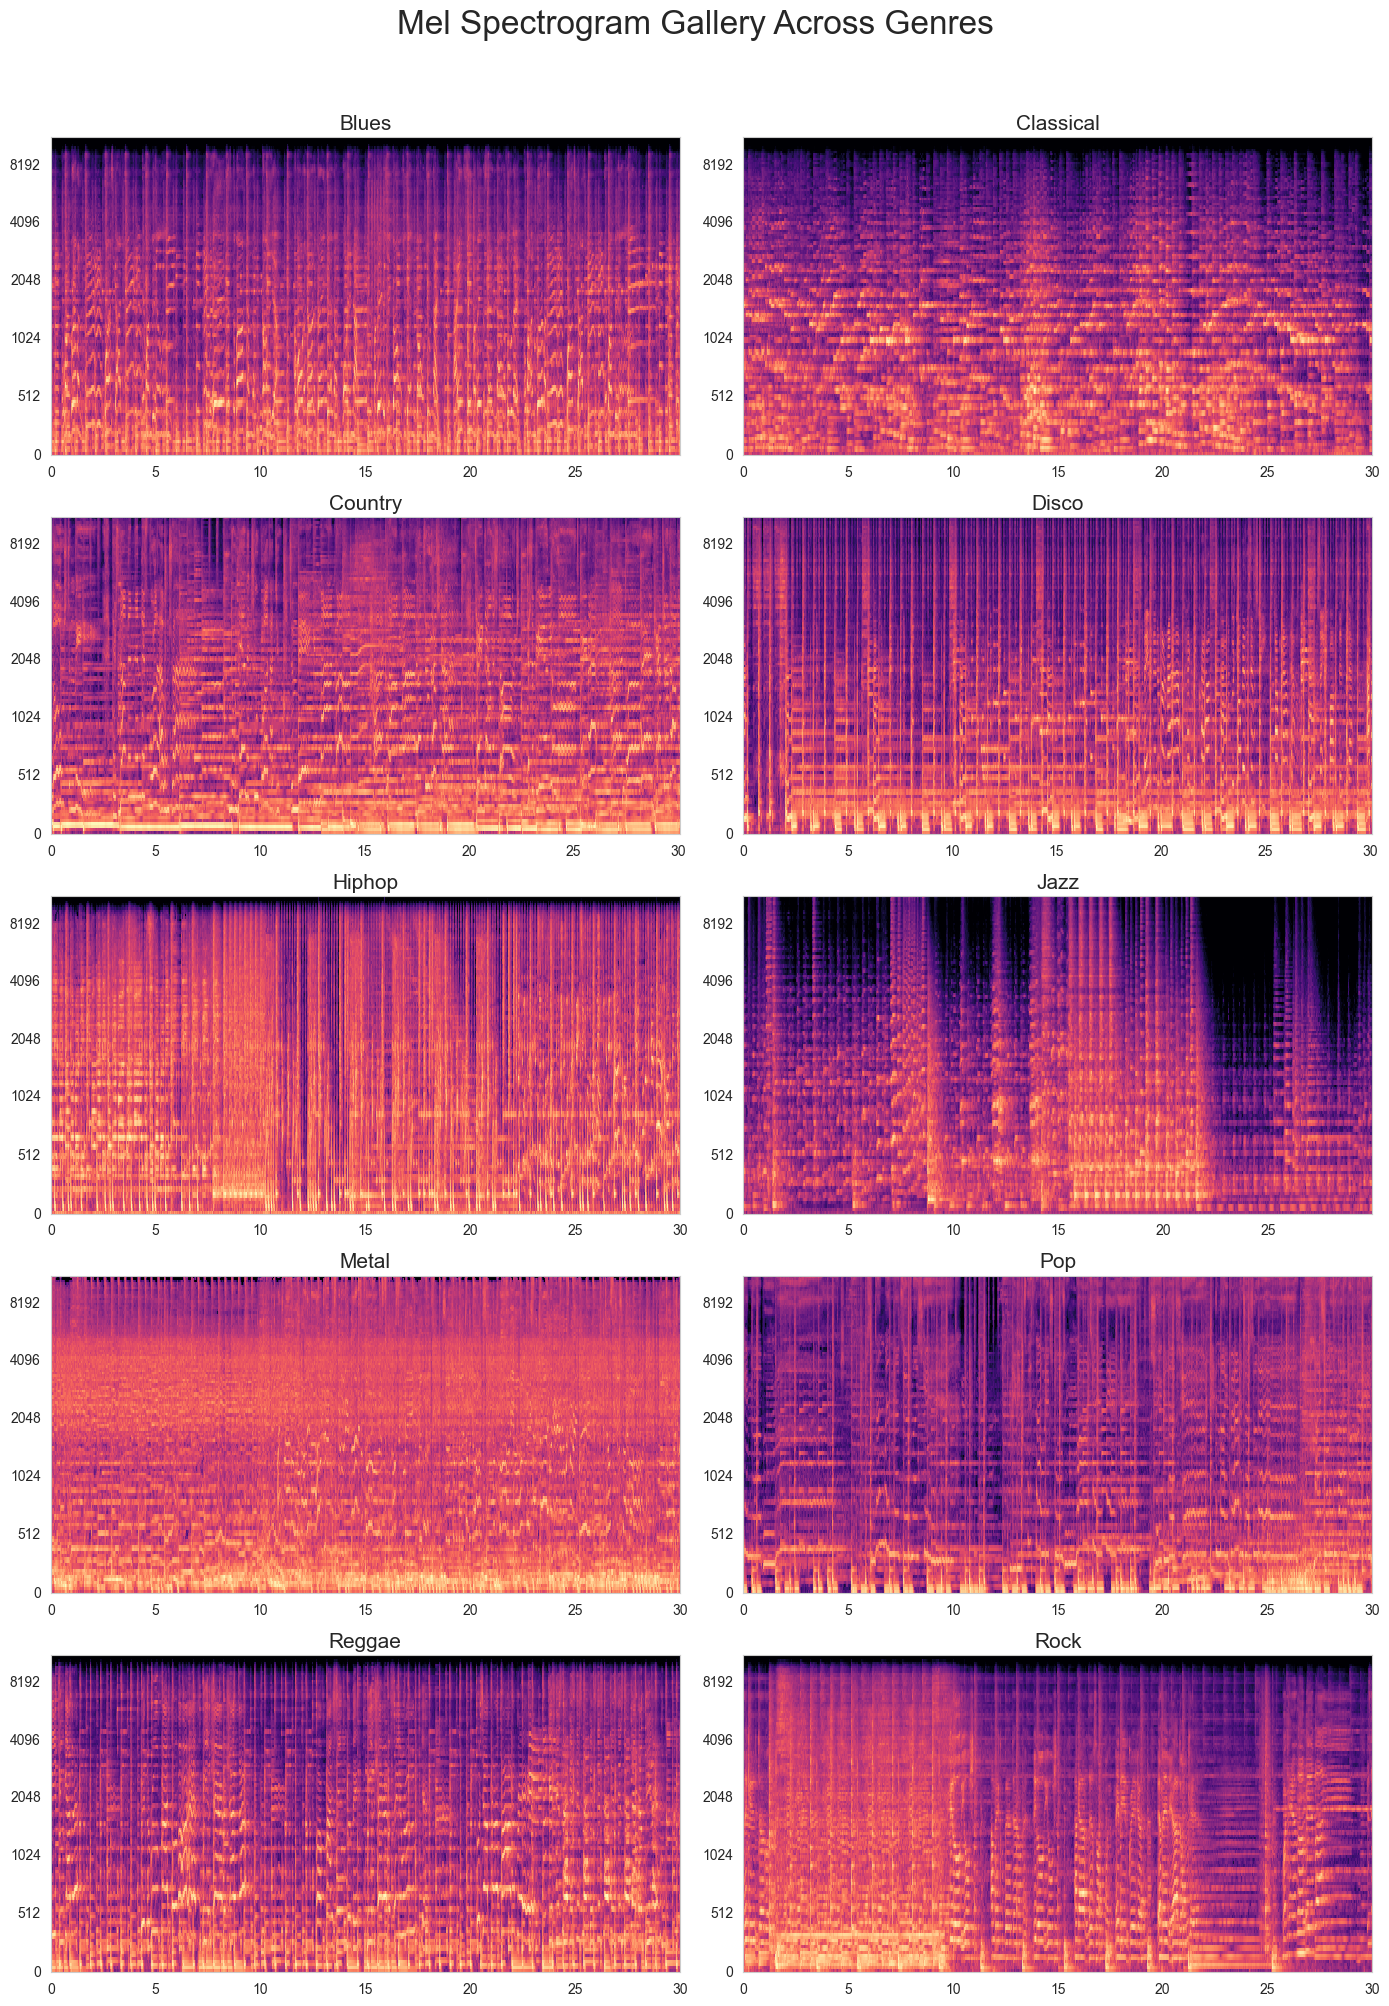

In [3]:
# ---
# ### **Part 2: Visualizing Audio Representations**
# ---

print("\nGenerating a gallery of Mel spectrograms for each genre...")

genres = sorted(metadata_df['genre'].unique())
fig, axs = plt.subplots(5, 2, figsize=(14, 22))
axs = axs.flatten()

for i, genre in enumerate(genres):
    # Find one representative file for the current genre
    filepath = metadata_df[metadata_df['genre'] == genre].iloc[0]['filepath']
    
    try:
        y, sr = librosa.load(filepath, sr=22050)
        y_trimmed, _ = librosa.effects.trim(y, top_db=20)
        
        mel_spec = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Plotting the spectrogram
        img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axs[i])
        axs[i].set_title(genre.title(), fontsize=15)
        axs[i].set_xlabel(None)
        axs[i].set_ylabel(None)
    except Exception as e:
        print(f"Could not process {filepath} for plotting: {e}")
        axs[i].set_title(f"{genre.title()} - Error", fontsize=15)

plt.suptitle('Mel Spectrogram Gallery Across Genres', fontsize=24, y=0.94)
plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()

In [4]:
# ---
# ### **Part 3: Statistical Feature Analysis**
# ---

print("\n--- Statistical Feature Analysis ---")
features_df = pd.read_csv(FEATURES_CSV_PATH)
# The 'filename' column in the CSV is not unique, let's make a genre column for easier plotting
features_df['genre'] = features_df['filename'].apply(lambda x: x.split('.')[0])


--- Statistical Feature Analysis ---


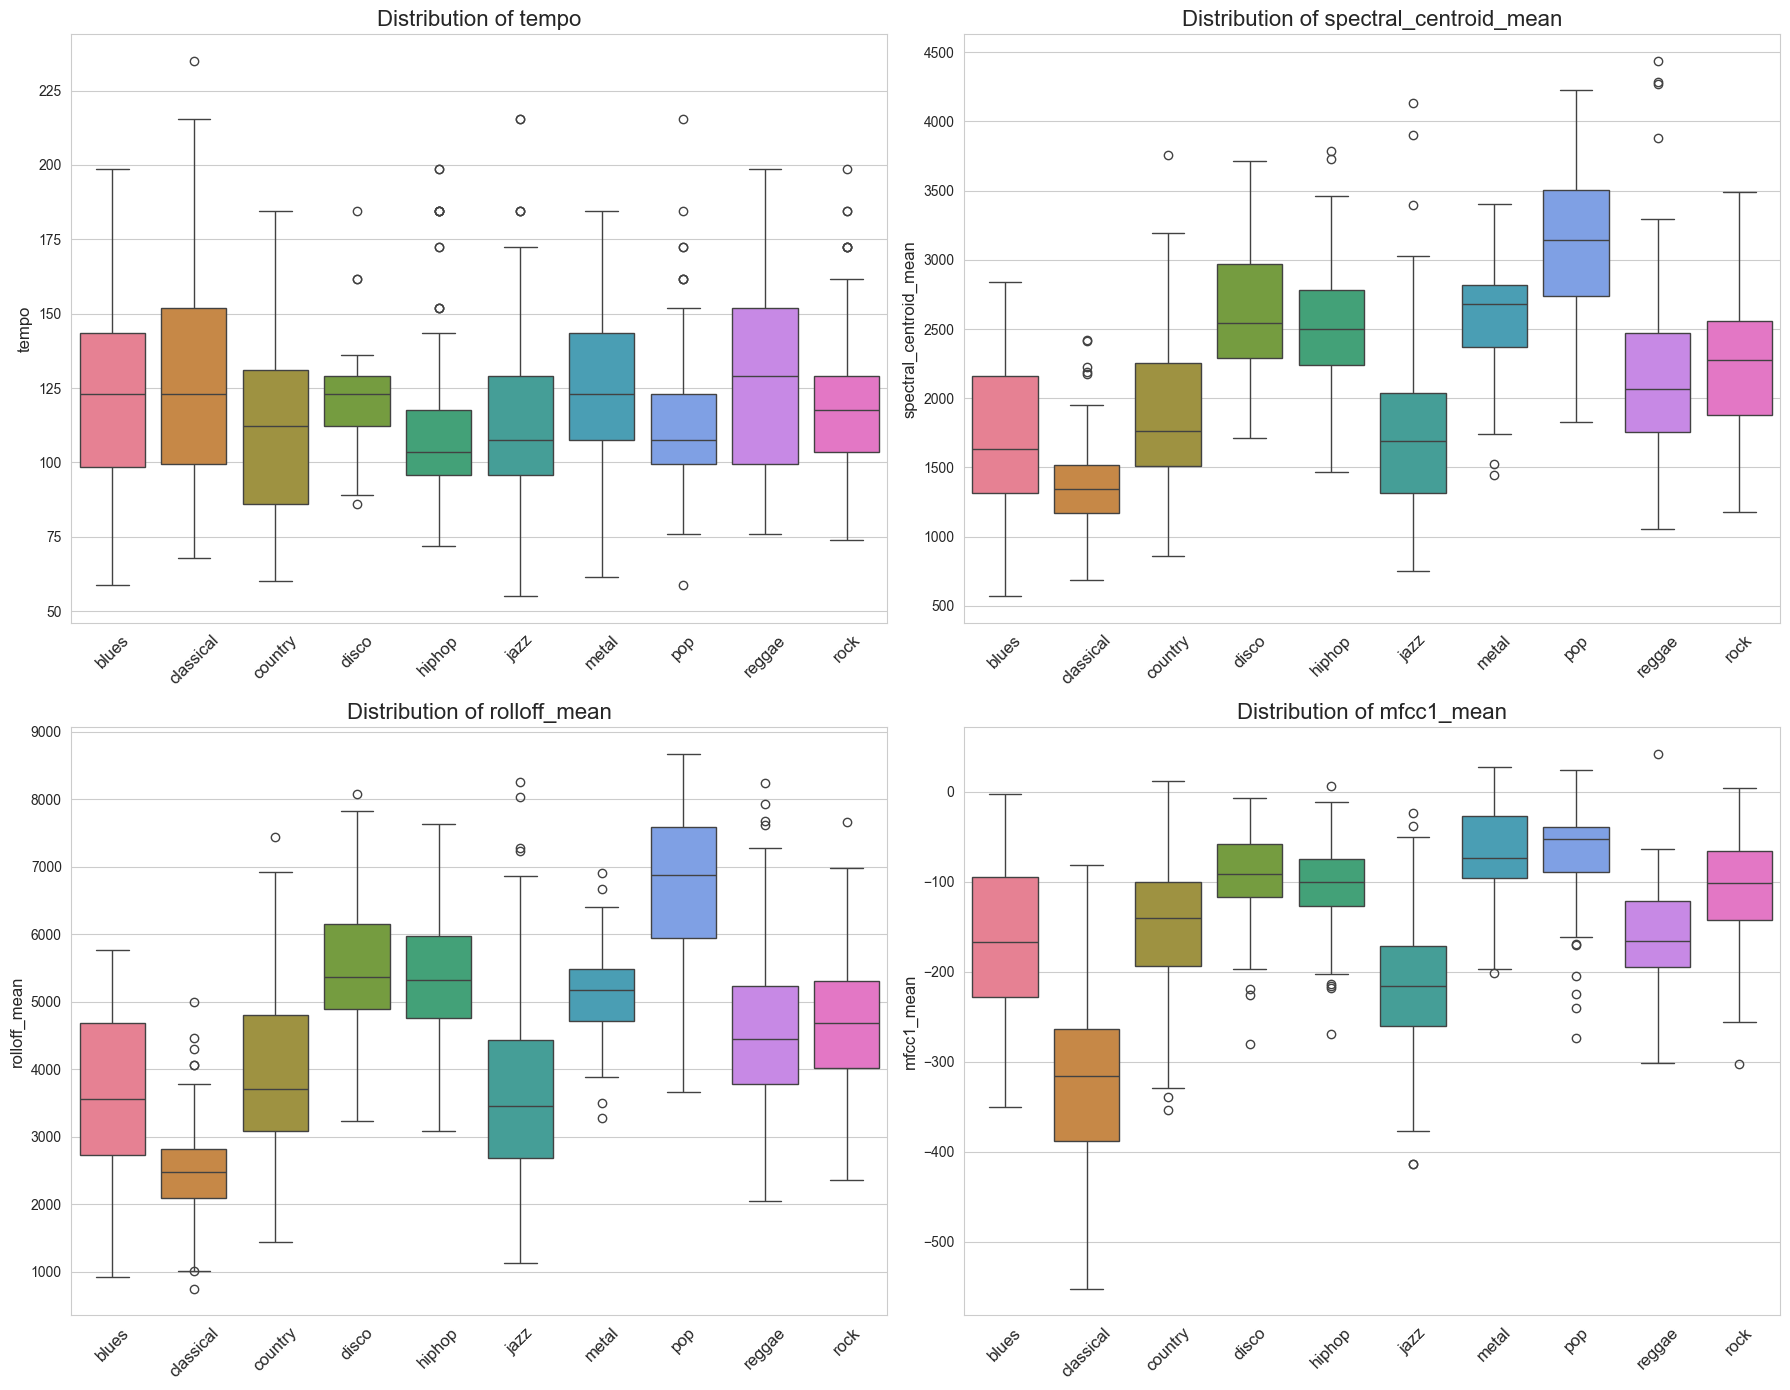

In [5]:
# #### 3.1: Feature Distributions via Boxplots
# Boxplots are excellent for comparing the distribution of a feature across multiple categories.

features_to_plot = ['tempo', 'spectral_centroid_mean', 'rolloff_mean', 'mfcc1_mean']

fig, axs = plt.subplots(2, 2, figsize=(18, 14))
axs = axs.flatten()

for i, feature in enumerate(features_to_plot):
    sns.boxplot(x='genre', y=feature, data=features_df, ax=axs[i], palette='husl')
    axs[i].set_title(f'Distribution of {feature}', fontsize=16)
    axs[i].tick_params(axis='x', rotation=45, labelsize=12)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(feature, fontsize=12)

plt.tight_layout()
plt.show()


Performing PCA on statistical features...


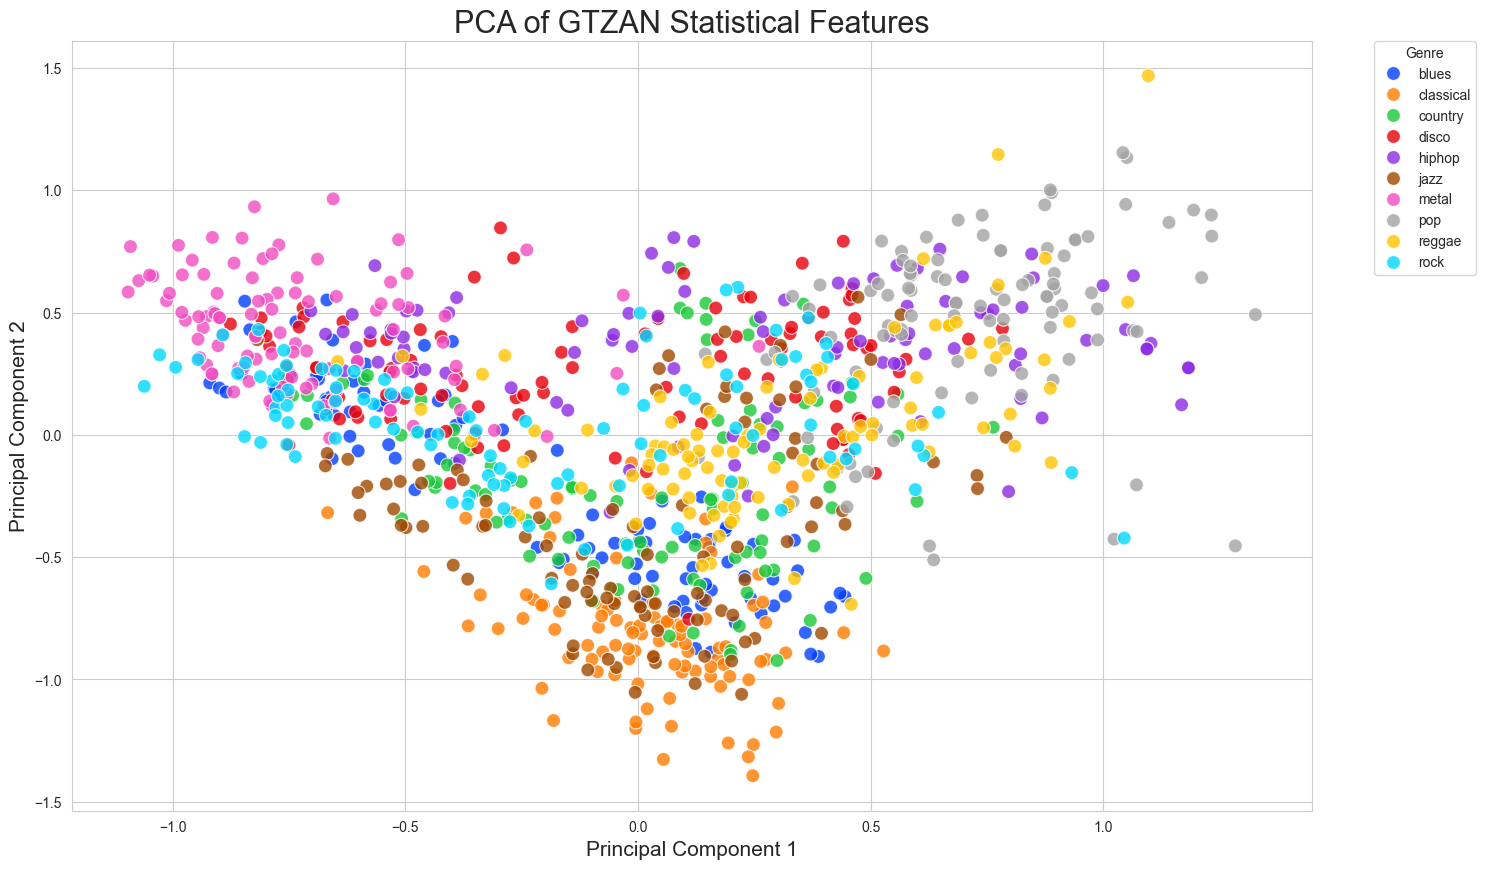

Explained Variance Ratio: PC1=0.25, PC2=0.22


In [6]:
# #### 3.2: Dimensionality Reduction with PCA
# PCA helps us visualize if the genres can be separated in a lower-dimensional space
# created by linear combinations of all 58 statistical features.

print("\nPerforming PCA on statistical features...")
X_pca = features_df.drop(['filename', 'length', 'label', 'genre'], axis=1)
y_pca = features_df['genre']

# Normalize the data before PCA
scaler = preprocessing.MinMaxScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_pca_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC 1', 'PC 2'])
pca_df['genre'] = y_pca

plt.figure(figsize=(16, 10))
sns.scatterplot(x='PC 1', y='PC 2', hue='genre', data=pca_df, alpha=0.8, s=100, palette='bright')
plt.title('PCA of GTZAN Statistical Features', fontsize=22)
plt.xlabel('Principal Component 1', fontsize=15)
plt.ylabel('Principal Component 2', fontsize=15)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

print(f"Explained Variance Ratio: PC1={pca.explained_variance_ratio_[0]:.2f}, PC2={pca.explained_variance_ratio_[1]:.2f}")


--- Investigating Intra-Genre Similarity (Dataset Bias) ---


Calculating Similarities: 100%|██████████| 10/10 [00:00<00:00, 401.98it/s]


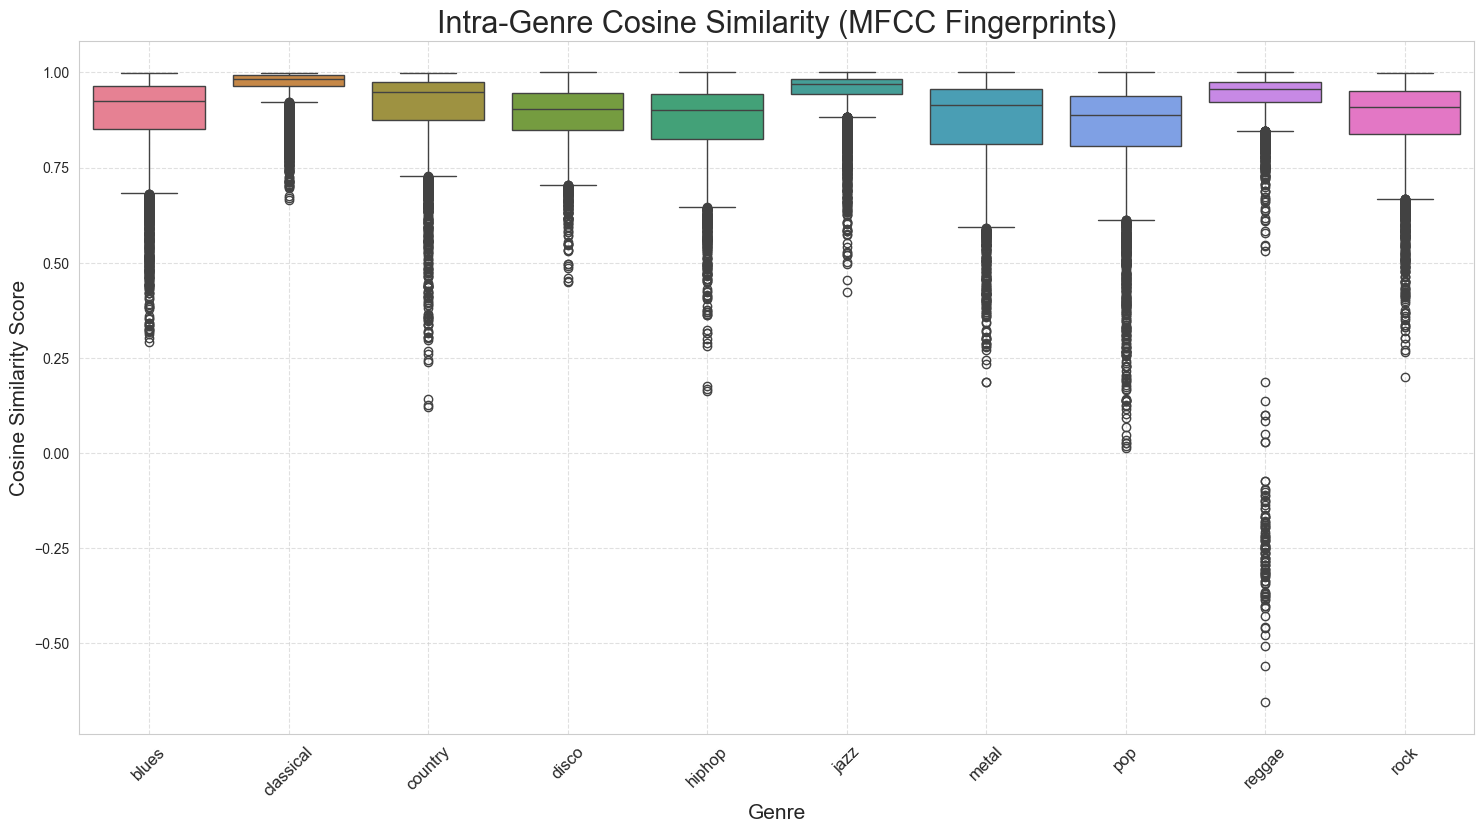

In [7]:
# ---
# ### **Part 4: Advanced EDA - Investigating Dataset Bias**
# ---
# A known issue with GTZAN is potential "artist bias," where a single artist or
# album might dominate a genre, making the model learn the artist's style rather
# than the genre itself. We can investigate this by measuring the internal similarity
# within each genre. A genre with unusually high self-similarity is a candidate for bias.

print("\n--- Investigating Intra-Genre Similarity (Dataset Bias) ---")

def get_mfcc_fingerprint(filepath, n_mfcc=20): # Use n_mfcc (singular)
    """Computes a stable 'fingerprint' of a track using the mean of its MFCCs."""
    try:
        y, sr = librosa.load(filepath, sr=22050, duration=30)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc) 
        return np.mean(mfccs, axis=1)
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

# We use our metadata_df as the source of truth for file paths and genres
# Create a new column for the fingerprint
metadata_df['fingerprint'] = [get_mfcc_fingerprint(fp) for fp in tqdm(metadata_df['filepath'], desc="Computing MFCC Fingerprints")]

# Drop any rows where fingerprint calculation failed
metadata_df.dropna(subset=['fingerprint'], inplace=True)

# Calculate pairwise cosine similarity for all tracks within each genre
similarity_data = []
# Make sure genres are sorted for consistent plot ordering
genres = sorted(metadata_df['genre'].unique())

for genre in tqdm(genres, desc="Calculating Similarities"):
    genre_df = metadata_df[metadata_df['genre'] == genre]
    genre_fingerprints = np.array(genre_df['fingerprint'].tolist())
    
    if len(genre_fingerprints) > 1:
        similarity_matrix = cosine_similarity(genre_fingerprints)
        # Get unique pairwise similarities (upper triangle of the matrix, excluding the diagonal)
        upper_triangle_indices = np.triu_indices_from(similarity_matrix, k=1)
        genre_similarities = similarity_matrix[upper_triangle_indices]
        
        for sim in genre_similarities:
            similarity_data.append({'genre': genre, 'similarity': sim})

similarity_df = pd.DataFrame(similarity_data)

# Visualize the distributions of similarity scores
plt.figure(figsize=(18, 9))
sns.boxplot(x='genre', y='similarity', data=similarity_df, palette='husl')
plt.title('Intra-Genre Cosine Similarity (MFCC Fingerprints)', fontsize=22)
plt.ylabel('Cosine Similarity Score', fontsize=15)
plt.xlabel('Genre', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [8]:
# =============================================================================
# Pipeline 1: CNN + RNN
# =============================================================================

# ---
# ### **Part 0: Setup and Imports**
# ---

import os
import json
import numpy as np
import pandas as pd
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(f"Using PyTorch version: {torch.__version__}")

# Set a consistent style for our plots
sns.set_style('whitegrid')

# Define paths and constants 
DATASET_PATH = "Data/genres_original"
JSON_PATH = "data_segments.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION


Using PyTorch version: 2.7.1+cu118


In [9]:
# ---
# Part 1: Data Preprocessing 
# ---

def prepare_data_for_dl(dataset_path, json_path, n_mels=128, n_fft=2048, hop_length=512, num_segments=10):
    data = { "mapping": [], "labels": [], "mel_spectrograms": [] }
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mel_vectors_per_segment = int(np.ceil(samples_per_segment / hop_length))

    print("Extracting and segmenting spectrograms...")
    dir_list = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    
    for i, genre_label in enumerate(dir_list):
        data["mapping"].append(genre_label)
        print(f"\nProcessing genre: {genre_label}")
        genre_path = os.path.join(dataset_path, genre_label)
        
        for f in sorted(os.listdir(genre_path)):
            if f.endswith(".wav"):
                file_path = os.path.join(genre_path, f)
                try:
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                    if len(signal) < SAMPLES_PER_TRACK:
                        signal = librosa.util.fix_length(signal, size=SAMPLES_PER_TRACK)

                    for s in range(num_segments):
                        start = samples_per_segment * s
                        finish = start + samples_per_segment
                        mel_spec = librosa.feature.melspectrogram(y=signal[start:finish], sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
                        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                        if mel_spec_db.shape[1] == num_mel_vectors_per_segment:
                            data["mel_spectrograms"].append(mel_spec_db.tolist())
                            data["labels"].append(i)
                            print(".", end="")
                except Exception as e:
                    print(f" Could not process {file_path}: {e}", end="")
                        
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
    print("\n\nData processing complete.")

if not os.path.exists(JSON_PATH):
    prepare_data_for_dl(DATASET_PATH, JSON_PATH)
else:
    print(f"'{JSON_PATH}' already exists. Skipping data preparation.")


Extracting and segmenting spectrograms...

Processing genre: blues
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [10]:
# ---
# ### **Part 2: PyTorch Dataset and DataLoaders**
# ---


def load_processed_data(json_path):
    with open(json_path, "r") as fp: data = json.load(fp)
    X = np.array(data["mel_spectrograms"])
    y = np.array(data["labels"])
    genres = data["mapping"]
    X = X[..., np.newaxis] # Add channel dimension -> (num_samples, height, width, channels)
    return X, y, genres

class GTZANDataset(Dataset):
    def __init__(self, X, y):
        # PyTorch expects channels-first format: (batch, channels, height, width)
        # So we transpose the dimensions from (N, H, W, C) to (N, C, H, W)
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Load and split the data
X, y, genres = load_processed_data(JSON_PATH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify=y_train)

# Create PyTorch Datasets
train_dataset = GTZANDataset(X_train, y_train)
val_dataset = GTZANDataset(X_val, y_val)
test_dataset = GTZANDataset(X_test, y_test)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print("\nPyTorch DataLoaders created.")
print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}, Test batches: {len(test_loader)}")


PyTorch DataLoaders created.
Training batches: 200, Validation batches: 50, Test batches: 63


In [11]:
# ---
# ### **Part 3: Define the CRNN Architecture in PyTorch**
# ---

class CRNN(nn.Module):
    def __init__(self, num_genres=10):
        super(CRNN, self).__init__()
        
        # CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            nn.Conv2d(64, 128, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        
        # We need to determine the input size for the GRU
        # This can be done by a dry run with a dummy input
        # Dummy input shape: (batch, channels, n_mels, time_steps) -> (1, 1, 128, 130)
        # After CNN, shape is (1, 128, 33, 34) -> (batch, channels, height, width)
        # For RNN, we want (batch, seq_len, features)
        # Here, seq_len = width (34), features = channels * height (128*33)
        self.gru = nn.GRU(input_size=128 * 33, hidden_size=64, batch_first=True)
        
        self.dropout = nn.Dropout(0.4)
        
        # Classifier Head
        self.fc = nn.Linear(64, num_genres)

    def forward(self, x):
        # Pass through CNN
        x = self.cnn(x)
        
        # Reshape for RNN
        batch_size, channels, height, width = x.size()
        x = x.permute(0, 3, 1, 2) # (batch, width, channels, height)
        x = x.reshape(batch_size, width, -1) # (batch, width, channels * height)
        
        # Pass through GRU
        # GRU returns output and final hidden state. We only need the output of the last time step.
        x, _ = self.gru(x)
        x = x[:, -1, :] # Get the last hidden state
        
        # Pass through classifier
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [12]:
# Instantiate model and set up for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(num_genres=len(genres)).to(device)
print(f"\nModel created and moved to {device}.")
print(model)


Model created and moved to cuda.
CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (gru): GRU(4224, 64, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=64, out_features=10, bias=True)
)


In [13]:
# ---
# ### **Part 4: Train the Model**
# ---

LEARNING_RATE = 0.0001
EPOCHS = 100
PATIENCE = 20 # For early stopping

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_val_loss = float('inf')
epochs_no_improve = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        train_pbar.set_postfix({'loss': loss.item(), 'acc': (predicted == labels).sum().item()/labels.size(0)})

    epoch_train_loss = running_loss / total_samples
    epoch_train_acc = correct_predictions / total_samples
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
    with torch.no_grad():
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            val_pbar.set_postfix({'loss': loss.item(), 'acc': (predicted == labels).sum().item()/labels.size(0)})

    epoch_val_loss = val_loss / total_samples
    epoch_val_acc = correct_predictions / total_samples
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} -> Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    # Early Stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_crnn_model.pth') # Save best model
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve == PATIENCE:
        print(f"Early stopping triggered after {PATIENCE} epochs with no improvement.")
        break

Epoch 1/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 89.29it/s, loss=1.85, acc=0.323]


Epoch 1/100 -> Train Loss: 2.0688, Train Acc: 0.2564 | Val Loss: 1.7937, Val Acc: 0.3884


Epoch 2/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.91it/s, loss=1.72, acc=0.419]


Epoch 2/100 -> Train Loss: 1.7297, Train Acc: 0.4072 | Val Loss: 1.5984, Val Acc: 0.4697


Epoch 3/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.07it/s, loss=1.6, acc=0.484] 


Epoch 3/100 -> Train Loss: 1.5431, Train Acc: 0.4866 | Val Loss: 1.4671, Val Acc: 0.5066


Epoch 4/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.07it/s, loss=1.49, acc=0.484]


Epoch 4/100 -> Train Loss: 1.4235, Train Acc: 0.5295 | Val Loss: 1.3660, Val Acc: 0.5629


Epoch 5/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 87.87it/s, loss=1.44, acc=0.516]


Epoch 5/100 -> Train Loss: 1.3055, Train Acc: 0.5833 | Val Loss: 1.2834, Val Acc: 0.5966


Epoch 6/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.74it/s, loss=1.34, acc=0.548] 


Epoch 6/100 -> Train Loss: 1.2182, Train Acc: 0.6172 | Val Loss: 1.2127, Val Acc: 0.6185


Epoch 7/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.58it/s, loss=1.33, acc=0.484] 


Epoch 7/100 -> Train Loss: 1.1337, Train Acc: 0.6477 | Val Loss: 1.1445, Val Acc: 0.6435


Epoch 8/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.60it/s, loss=1.22, acc=0.548] 


Epoch 8/100 -> Train Loss: 1.0610, Train Acc: 0.6781 | Val Loss: 1.0833, Val Acc: 0.6679


Epoch 9/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.58it/s, loss=1.2, acc=0.581]  


Epoch 9/100 -> Train Loss: 0.9816, Train Acc: 0.7098 | Val Loss: 1.0363, Val Acc: 0.6829


Epoch 10/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.58it/s, loss=1.14, acc=0.645] 


Epoch 10/100 -> Train Loss: 0.9200, Train Acc: 0.7369 | Val Loss: 0.9914, Val Acc: 0.7061


Epoch 11/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.58it/s, loss=1.02, acc=0.742] 


Epoch 11/100 -> Train Loss: 0.8532, Train Acc: 0.7572 | Val Loss: 0.9333, Val Acc: 0.7261


Epoch 12/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.91it/s, loss=1.02, acc=0.645] 


Epoch 12/100 -> Train Loss: 0.7941, Train Acc: 0.7807 | Val Loss: 0.9044, Val Acc: 0.7273


Epoch 13/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.07it/s, loss=1.01, acc=0.71]  


Epoch 13/100 -> Train Loss: 0.7400, Train Acc: 0.7984 | Val Loss: 0.8775, Val Acc: 0.7373


Epoch 14/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.57it/s, loss=0.862, acc=0.871]


Epoch 14/100 -> Train Loss: 0.6881, Train Acc: 0.8176 | Val Loss: 0.8413, Val Acc: 0.7542


Epoch 15/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.74it/s, loss=0.906, acc=0.774]


Epoch 15/100 -> Train Loss: 0.6322, Train Acc: 0.8386 | Val Loss: 0.8143, Val Acc: 0.7473


Epoch 16/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.58it/s, loss=0.842, acc=0.806]


Epoch 16/100 -> Train Loss: 0.5930, Train Acc: 0.8492 | Val Loss: 0.7768, Val Acc: 0.7692


Epoch 17/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.07it/s, loss=0.808, acc=0.806]


Epoch 17/100 -> Train Loss: 0.5473, Train Acc: 0.8708 | Val Loss: 0.7624, Val Acc: 0.7630


Epoch 18/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 88.97it/s, loss=0.753, acc=0.806]


Epoch 18/100 -> Train Loss: 0.5037, Train Acc: 0.8791 | Val Loss: 0.7326, Val Acc: 0.7849


Epoch 19/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.58it/s, loss=0.673, acc=0.903]


Epoch 19/100 -> Train Loss: 0.4680, Train Acc: 0.8911 | Val Loss: 0.7184, Val Acc: 0.7817


Epoch 20/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.74it/s, loss=0.728, acc=0.839]


Epoch 20/100 -> Train Loss: 0.4252, Train Acc: 0.9046 | Val Loss: 0.6855, Val Acc: 0.7955


Epoch 21/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.74it/s, loss=0.623, acc=0.935]


Epoch 21/100 -> Train Loss: 0.3968, Train Acc: 0.9099 | Val Loss: 0.6707, Val Acc: 0.8036


Epoch 22/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 89.77it/s, loss=0.664, acc=0.903]


Epoch 22/100 -> Train Loss: 0.3579, Train Acc: 0.9266 | Val Loss: 0.6516, Val Acc: 0.8074


Epoch 23/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.24it/s, loss=0.627, acc=0.935]


Epoch 23/100 -> Train Loss: 0.3312, Train Acc: 0.9318 | Val Loss: 0.6340, Val Acc: 0.8124


Epoch 24/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.42it/s, loss=0.61, acc=0.871] 


Epoch 24/100 -> Train Loss: 0.3025, Train Acc: 0.9406 | Val Loss: 0.6288, Val Acc: 0.8005


Epoch 25/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.24it/s, loss=0.551, acc=0.871]


Epoch 25/100 -> Train Loss: 0.2756, Train Acc: 0.9498 | Val Loss: 0.5990, Val Acc: 0.8130


Epoch 26/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.91it/s, loss=0.565, acc=0.903]


Epoch 26/100 -> Train Loss: 0.2509, Train Acc: 0.9557 | Val Loss: 0.6090, Val Acc: 0.8068


Epoch 27/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 86.21it/s, loss=0.529, acc=0.903]


Epoch 27/100 -> Train Loss: 0.2294, Train Acc: 0.9600 | Val Loss: 0.5858, Val Acc: 0.8161


Epoch 28/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.07it/s, loss=0.511, acc=0.903]


Epoch 28/100 -> Train Loss: 0.2075, Train Acc: 0.9668 | Val Loss: 0.5786, Val Acc: 0.8168


Epoch 29/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.07it/s, loss=0.496, acc=0.903]


Epoch 29/100 -> Train Loss: 0.1915, Train Acc: 0.9682 | Val Loss: 0.5663, Val Acc: 0.8255


Epoch 30/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.07it/s, loss=0.474, acc=0.903]


Epoch 30/100 -> Train Loss: 0.1741, Train Acc: 0.9762 | Val Loss: 0.5509, Val Acc: 0.8324


Epoch 31/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 87.57it/s, loss=0.458, acc=0.935]


Epoch 31/100 -> Train Loss: 0.1614, Train Acc: 0.9751 | Val Loss: 0.5601, Val Acc: 0.8180


Epoch 32/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.58it/s, loss=0.431, acc=0.935]


Epoch 32/100 -> Train Loss: 0.1486, Train Acc: 0.9804 | Val Loss: 0.5467, Val Acc: 0.8286


Epoch 33/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.24it/s, loss=0.517, acc=0.871]


Epoch 33/100 -> Train Loss: 0.1328, Train Acc: 0.9842 | Val Loss: 0.5525, Val Acc: 0.8268


Epoch 34/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.91it/s, loss=0.508, acc=0.839]


Epoch 34/100 -> Train Loss: 0.1266, Train Acc: 0.9836 | Val Loss: 0.5452, Val Acc: 0.8274


Epoch 35/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.91it/s, loss=0.558, acc=0.871]


Epoch 35/100 -> Train Loss: 0.1107, Train Acc: 0.9881 | Val Loss: 0.5334, Val Acc: 0.8330


Epoch 36/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.74it/s, loss=0.52, acc=0.935] 


Epoch 36/100 -> Train Loss: 0.1015, Train Acc: 0.9892 | Val Loss: 0.5411, Val Acc: 0.8305


Epoch 37/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.91it/s, loss=0.479, acc=0.903]


Epoch 37/100 -> Train Loss: 0.0960, Train Acc: 0.9897 | Val Loss: 0.5185, Val Acc: 0.8418


Epoch 38/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.58it/s, loss=0.45, acc=0.935] 


Epoch 38/100 -> Train Loss: 0.0902, Train Acc: 0.9898 | Val Loss: 0.5161, Val Acc: 0.8393


Epoch 39/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.57it/s, loss=0.398, acc=0.968]


Epoch 39/100 -> Train Loss: 0.0842, Train Acc: 0.9908 | Val Loss: 0.5102, Val Acc: 0.8386


Epoch 40/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.58it/s, loss=0.426, acc=0.903]


Epoch 40/100 -> Train Loss: 0.0797, Train Acc: 0.9906 | Val Loss: 0.5007, Val Acc: 0.8462


Epoch 41/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.91it/s, loss=0.442, acc=0.903]


Epoch 41/100 -> Train Loss: 0.0676, Train Acc: 0.9923 | Val Loss: 0.5110, Val Acc: 0.8374


Epoch 42/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.41it/s, loss=0.434, acc=0.903]


Epoch 42/100 -> Train Loss: 0.0650, Train Acc: 0.9945 | Val Loss: 0.5050, Val Acc: 0.8455


Epoch 43/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.41it/s, loss=0.423, acc=0.903]


Epoch 43/100 -> Train Loss: 0.0589, Train Acc: 0.9944 | Val Loss: 0.5164, Val Acc: 0.8412


Epoch 44/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.74it/s, loss=0.494, acc=0.871]


Epoch 44/100 -> Train Loss: 0.0558, Train Acc: 0.9958 | Val Loss: 0.5039, Val Acc: 0.8324


Epoch 45/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.09it/s, loss=0.431, acc=0.903]


Epoch 45/100 -> Train Loss: 0.0521, Train Acc: 0.9955 | Val Loss: 0.5253, Val Acc: 0.8311


Epoch 46/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.24it/s, loss=0.513, acc=0.839]


Epoch 46/100 -> Train Loss: 0.0509, Train Acc: 0.9955 | Val Loss: 0.5241, Val Acc: 0.8349


Epoch 47/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.07it/s, loss=0.427, acc=0.935]


Epoch 47/100 -> Train Loss: 0.0431, Train Acc: 0.9981 | Val Loss: 0.5089, Val Acc: 0.8499


Epoch 48/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.74it/s, loss=0.442, acc=0.839]


Epoch 48/100 -> Train Loss: 0.0408, Train Acc: 0.9975 | Val Loss: 0.5217, Val Acc: 0.8368


Epoch 49/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 89.93it/s, loss=0.614, acc=0.871]


Epoch 49/100 -> Train Loss: 0.0457, Train Acc: 0.9942 | Val Loss: 0.5458, Val Acc: 0.8336


Epoch 50/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.58it/s, loss=0.44, acc=0.871] 


Epoch 50/100 -> Train Loss: 0.0404, Train Acc: 0.9959 | Val Loss: 0.5153, Val Acc: 0.8393


Epoch 51/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 92.08it/s, loss=0.538, acc=0.871]


Epoch 51/100 -> Train Loss: 0.0355, Train Acc: 0.9966 | Val Loss: 0.5148, Val Acc: 0.8443


Epoch 52/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.07it/s, loss=0.411, acc=0.903]


Epoch 52/100 -> Train Loss: 0.0379, Train Acc: 0.9953 | Val Loss: 0.5120, Val Acc: 0.8355


Epoch 53/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.25it/s, loss=0.453, acc=0.871]


Epoch 53/100 -> Train Loss: 0.0365, Train Acc: 0.9958 | Val Loss: 0.5164, Val Acc: 0.8405


Epoch 54/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.91it/s, loss=0.45, acc=0.871] 


Epoch 54/100 -> Train Loss: 0.0351, Train Acc: 0.9961 | Val Loss: 0.5131, Val Acc: 0.8468


Epoch 55/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.50it/s, loss=0.525, acc=0.871]


Epoch 55/100 -> Train Loss: 0.0299, Train Acc: 0.9969 | Val Loss: 0.4981, Val Acc: 0.8499


Epoch 56/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.58it/s, loss=0.534, acc=0.871]


Epoch 56/100 -> Train Loss: 0.0246, Train Acc: 0.9978 | Val Loss: 0.4947, Val Acc: 0.8487


Epoch 57/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.25it/s, loss=0.48, acc=0.903] 


Epoch 57/100 -> Train Loss: 0.0294, Train Acc: 0.9962 | Val Loss: 0.5194, Val Acc: 0.8343


Epoch 58/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.58it/s, loss=0.588, acc=0.839]


Epoch 58/100 -> Train Loss: 0.0295, Train Acc: 0.9956 | Val Loss: 0.5139, Val Acc: 0.8474


Epoch 59/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.91it/s, loss=0.492, acc=0.839]


Epoch 59/100 -> Train Loss: 0.0285, Train Acc: 0.9964 | Val Loss: 0.5154, Val Acc: 0.8380


Epoch 60/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.74it/s, loss=0.516, acc=0.871]


Epoch 60/100 -> Train Loss: 0.0231, Train Acc: 0.9980 | Val Loss: 0.5013, Val Acc: 0.8562


Epoch 61/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.74it/s, loss=0.518, acc=0.903]


Epoch 61/100 -> Train Loss: 0.0246, Train Acc: 0.9973 | Val Loss: 0.5089, Val Acc: 0.8474


Epoch 62/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 88.97it/s, loss=0.416, acc=0.935]


Epoch 62/100 -> Train Loss: 0.0218, Train Acc: 0.9980 | Val Loss: 0.5091, Val Acc: 0.8480


Epoch 63/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.41it/s, loss=0.343, acc=0.968]


Epoch 63/100 -> Train Loss: 0.0292, Train Acc: 0.9961 | Val Loss: 0.5183, Val Acc: 0.8487


Epoch 64/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.42it/s, loss=0.357, acc=0.968]


Epoch 64/100 -> Train Loss: 0.0308, Train Acc: 0.9958 | Val Loss: 0.5033, Val Acc: 0.8605


Epoch 65/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.07it/s, loss=0.33, acc=0.935] 


Epoch 65/100 -> Train Loss: 0.0265, Train Acc: 0.9964 | Val Loss: 0.5068, Val Acc: 0.8580


Epoch 66/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.71it/s, loss=0.425, acc=0.903]


Epoch 66/100 -> Train Loss: 0.0198, Train Acc: 0.9977 | Val Loss: 0.5144, Val Acc: 0.8518


Epoch 67/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 84.75it/s, loss=0.522, acc=0.806]


Epoch 67/100 -> Train Loss: 0.0199, Train Acc: 0.9970 | Val Loss: 0.5159, Val Acc: 0.8474


Epoch 68/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.24it/s, loss=0.854, acc=0.742]


Epoch 68/100 -> Train Loss: 0.0257, Train Acc: 0.9950 | Val Loss: 0.5913, Val Acc: 0.8261


Epoch 69/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.91it/s, loss=0.414, acc=0.871] 


Epoch 69/100 -> Train Loss: 0.0262, Train Acc: 0.9970 | Val Loss: 0.4922, Val Acc: 0.8537


Epoch 70/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.58it/s, loss=0.583, acc=0.871]


Epoch 70/100 -> Train Loss: 0.0217, Train Acc: 0.9962 | Val Loss: 0.4996, Val Acc: 0.8487


Epoch 71/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.58it/s, loss=0.422, acc=0.903]


Epoch 71/100 -> Train Loss: 0.0279, Train Acc: 0.9953 | Val Loss: 0.5207, Val Acc: 0.8462


Epoch 72/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 87.87it/s, loss=0.571, acc=0.903]


Epoch 72/100 -> Train Loss: 0.0175, Train Acc: 0.9984 | Val Loss: 0.5110, Val Acc: 0.8643


Epoch 73/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.91it/s, loss=0.4, acc=0.903]   


Epoch 73/100 -> Train Loss: 0.0172, Train Acc: 0.9977 | Val Loss: 0.4987, Val Acc: 0.8599


Epoch 74/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.95it/s, loss=0.343, acc=0.935]


Epoch 74/100 -> Train Loss: 0.0158, Train Acc: 0.9977 | Val Loss: 0.5070, Val Acc: 0.8574


Epoch 75/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.91it/s, loss=0.372, acc=0.903] 


Epoch 75/100 -> Train Loss: 0.0128, Train Acc: 0.9981 | Val Loss: 0.5075, Val Acc: 0.8537


Epoch 76/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.58it/s, loss=0.533, acc=0.871]


Epoch 76/100 -> Train Loss: 0.0155, Train Acc: 0.9972 | Val Loss: 0.5377, Val Acc: 0.8499


Epoch 77/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.42it/s, loss=0.433, acc=0.903]


Epoch 77/100 -> Train Loss: 0.0145, Train Acc: 0.9983 | Val Loss: 0.5263, Val Acc: 0.8455


Epoch 78/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.42it/s, loss=0.429, acc=0.903]


Epoch 78/100 -> Train Loss: 0.0159, Train Acc: 0.9980 | Val Loss: 0.5302, Val Acc: 0.8487


Epoch 79/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.74it/s, loss=0.513, acc=0.935]


Epoch 79/100 -> Train Loss: 0.0195, Train Acc: 0.9964 | Val Loss: 0.5385, Val Acc: 0.8505


Epoch 80/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.17it/s, loss=0.391, acc=0.935]


Epoch 80/100 -> Train Loss: 0.0150, Train Acc: 0.9980 | Val Loss: 0.5483, Val Acc: 0.8468


Epoch 81/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 87.57it/s, loss=0.371, acc=0.935]


Epoch 81/100 -> Train Loss: 0.0205, Train Acc: 0.9962 | Val Loss: 0.5408, Val Acc: 0.8462


Epoch 82/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.07it/s, loss=0.59, acc=0.871] 


Epoch 82/100 -> Train Loss: 0.0191, Train Acc: 0.9970 | Val Loss: 0.5229, Val Acc: 0.8555


Epoch 83/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 89.93it/s, loss=0.54, acc=0.903] 


Epoch 83/100 -> Train Loss: 0.0138, Train Acc: 0.9978 | Val Loss: 0.5288, Val Acc: 0.8574


Epoch 84/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.74it/s, loss=0.397, acc=0.935]


Epoch 84/100 -> Train Loss: 0.0112, Train Acc: 0.9986 | Val Loss: 0.5293, Val Acc: 0.8537


Epoch 85/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 87.41it/s, loss=0.512, acc=0.839]


Epoch 85/100 -> Train Loss: 0.0108, Train Acc: 0.9986 | Val Loss: 0.6091, Val Acc: 0.8330


Epoch 86/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.25it/s, loss=0.561, acc=0.903]


Epoch 86/100 -> Train Loss: 0.0253, Train Acc: 0.9955 | Val Loss: 0.5348, Val Acc: 0.8493


Epoch 87/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 91.07it/s, loss=0.531, acc=0.903]


Epoch 87/100 -> Train Loss: 0.0157, Train Acc: 0.9970 | Val Loss: 0.5387, Val Acc: 0.8512


Epoch 88/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.87it/s, loss=0.491, acc=0.903]


Epoch 88/100 -> Train Loss: 0.0238, Train Acc: 0.9933 | Val Loss: 0.5721, Val Acc: 0.8543


Epoch 89/100 [Val]: 100%|██████████| 50/50 [00:00<00:00, 90.42it/s, loss=0.534, acc=0.903]

Epoch 89/100 -> Train Loss: 0.0261, Train Acc: 0.9931 | Val Loss: 0.5445, Val Acc: 0.8474
Early stopping triggered after 20 epochs with no improvement.



Plotting training history...


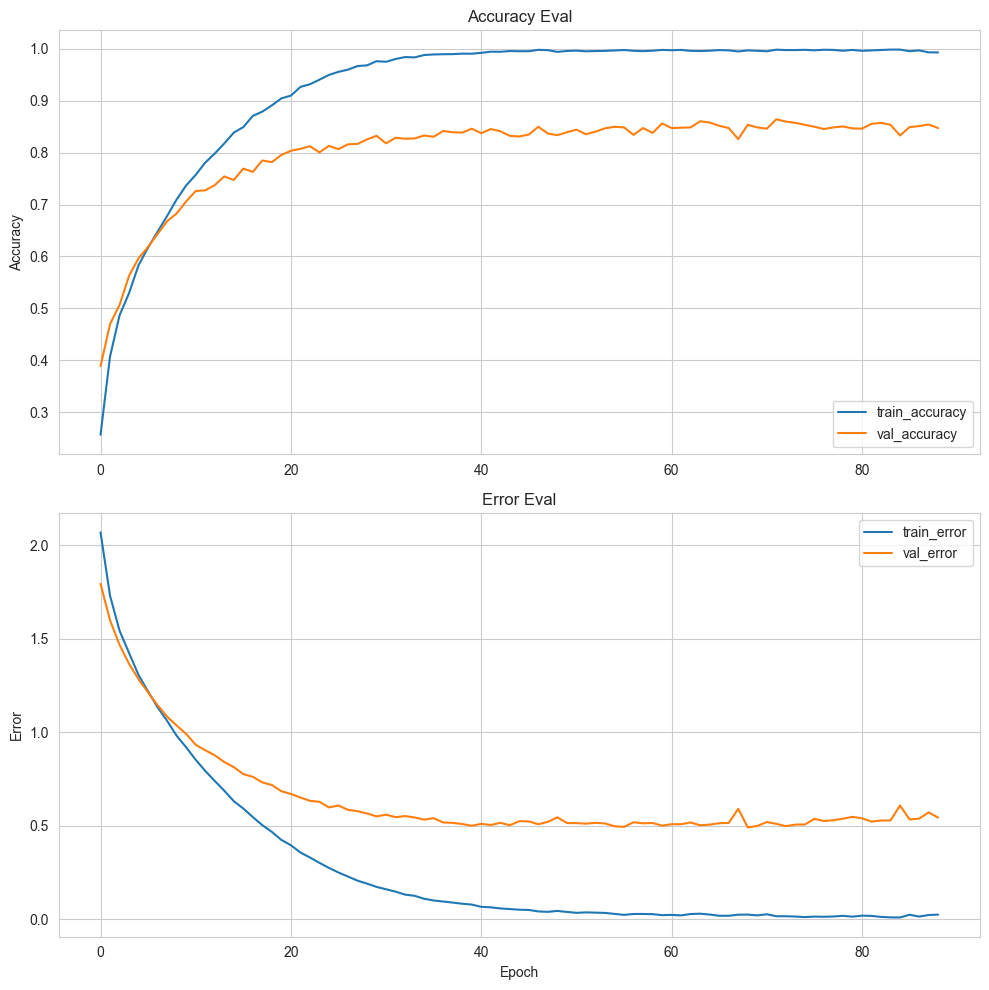


Evaluating on the test set...


Testing: 100%|██████████| 63/63 [00:00<00:00, 95.60it/s]



Test Accuracy: 0.850
Test Loss: 0.498


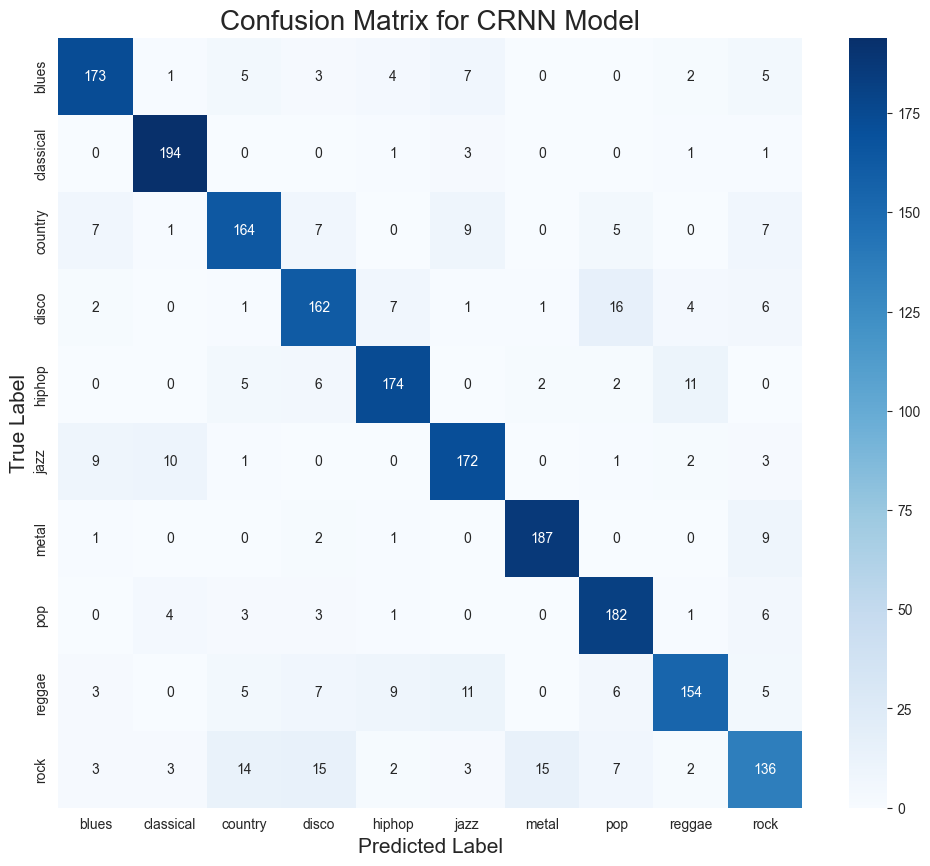

In [14]:
# ---
# ### **Part 5: Evaluate the Model**
# ---

# Load the best model weights for final evaluation
model.load_state_dict(torch.load('best_crnn_model.pth'))

def plot_history_pytorch(history):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    axs[0].plot(history["train_acc"], label="train_accuracy")
    axs[0].plot(history["val_acc"], label="val_accuracy")
    axs[0].set_ylabel("Accuracy"); axs[0].legend(loc="lower right"); axs[0].set_title("Accuracy Eval")
    axs[1].plot(history["train_loss"], label="train_error")
    axs[1].plot(history["val_loss"], label="val_error")
    axs[1].set_ylabel("Error"); axs[1].set_xlabel("Epoch"); axs[1].legend(loc="upper right"); axs[1].set_title("Error Eval")
    plt.tight_layout(); plt.show()

print("\nPlotting training history...")
plot_history_pytorch(history)

# Final evaluation on the test set
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct_predictions = 0
total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_test_loss = test_loss / total_samples
final_test_acc = correct_predictions / total_samples

print(f"\nTest Accuracy: {final_test_acc:.3f}")
print(f"Test Loss: {final_test_loss:.3f}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=genres, yticklabels=genres, cmap='Blues')
plt.title('Confusion Matrix for CRNN Model', fontsize=20)
plt.ylabel('True Label', fontsize=15)
plt.xlabel('Predicted Label', fontsize=15)
plt.show()

In [15]:
################################################################################
#                                                                              #
#      ADVANCED CONVOLUTIONAL RECURRENT NEURAL NETWORK                         #
#                                                                              #
################################################################################

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print("\n--- Starting Advanced CRNN Pipeline ---")

# --- 1. Data Loading and Preparation---
JSON_PATH = "data_segments.json"

def load_processed_data(json_path):
    with open(json_path, "r") as fp:
        data = json.load(fp)
    X = np.array(data["mel_spectrograms"])
    y = np.array(data["labels"])
    genres = data["mapping"]
    X = X[..., np.newaxis] # Add channel dimension -> (num_samples, height, width, channels)
    return X, y, genres

class GTZANDataset(Dataset):
    def __init__(self, X, y):
        # PyTorch expects channels-first format: (batch, channels, height, width)
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


--- Starting Advanced CRNN Pipeline ---


In [16]:
# Load and split the data
X, y, genres = load_processed_data(JSON_PATH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify=y_train)

# Create Datasets and DataLoaders
train_dataset = GTZANDataset(X_train, y_train)
val_dataset = GTZANDataset(X_val, y_val)
test_dataset = GTZANDataset(X_test, y_test)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print("Data loaded and prepared for Advanced CRNN.")

Data loaded and prepared for Advanced CRNN.


In [17]:
# --- 2. Advanced Model Definition ---
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, rnn_outputs):
        # rnn_outputs shape: (batch_size, seq_len, hidden_size)
        # attention_weights shape: (batch_size, seq_len, 1)
        attention_weights = F.softmax(self.attention(rnn_outputs), dim=1)
        
        # context_vector shape: (batch_size, hidden_size)
        context_vector = torch.sum(attention_weights * rnn_outputs, dim=1)
        return context_vector

class AdvancedCRNN(nn.Module):
    def __init__(self, num_genres=10):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(256), nn.MaxPool2d(2),
        )
        
        self.gru_hidden_size = 128
        # CNN output is (batch, 256, 8, 8) -> features = 256 * 8
        self.gru = nn.GRU(
            input_size=256 * 8,
            hidden_size=self.gru_hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )
        
        self.attention = Attention(hidden_size=self.gru_hidden_size * 2)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.gru_hidden_size * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_genres)
        )

    def forward(self, x):
        x = self.cnn(x)
        batch_size, channels, height, width = x.size()
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(batch_size, width, -1)
        
        gru_outputs, _ = self.gru(x)
        attention_output = self.attention(gru_outputs)
        predictions = self.classifier(attention_output)
        return predictions

In [43]:
print(adv_model)

AdvancedCRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

In [18]:
# --- 3. Training Loop ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
adv_model = AdvancedCRNN(num_genres=len(genres)).to(device)
print(f"AdvancedCRNN model created on {device}.")

LEARNING_RATE = 3e-4
EPOCHS = 100
PATIENCE = 20

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(adv_model.parameters(), lr=LEARNING_RATE)

history_adv = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(EPOCHS):
    adv_model.train()
    running_loss, correct_predictions, total_samples = 0.0, 0, 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = adv_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        train_pbar.set_postfix({'loss': loss.item(), 'acc': (predicted == labels).sum().item()/labels.size(0)})
        
    epoch_train_loss = running_loss / total_samples
    epoch_train_acc = correct_predictions / total_samples
    history_adv['train_loss'].append(epoch_train_loss)
    history_adv['train_acc'].append(epoch_train_acc)
    
    adv_model.eval()
    val_loss, correct_predictions, total_samples = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = adv_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
    epoch_val_loss = val_loss / total_samples
    epoch_val_acc = correct_predictions / total_samples
    history_adv['val_loss'].append(epoch_val_loss)
    history_adv['val_acc'].append(epoch_val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} -> Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(adv_model.state_dict(), 'best_advanced_crnn_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve == PATIENCE:
        print(f"Early stopping triggered after {PATIENCE} epochs.")
        break


AdvancedCRNN model created on cuda.


Epoch 1/100 [Train]: 100%|██████████| 200/200 [00:06<00:00, 32.36it/s, loss=1.04, acc=0.6]   


Epoch 1/100 -> Train Loss: 1.5275, Train Acc: 0.4664 | Val Loss: 0.9207, Val Acc: 0.7073


Epoch 2/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.60it/s, loss=0.593, acc=0.84] 


Epoch 2/100 -> Train Loss: 0.8836, Train Acc: 0.7073 | Val Loss: 0.7622, Val Acc: 0.7448


Epoch 3/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.65it/s, loss=1.11, acc=0.68]  


Epoch 3/100 -> Train Loss: 0.6217, Train Acc: 0.7993 | Val Loss: 0.6631, Val Acc: 0.7774


Epoch 4/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.65it/s, loss=0.475, acc=0.88] 


Epoch 4/100 -> Train Loss: 0.4471, Train Acc: 0.8550 | Val Loss: 0.5101, Val Acc: 0.8311


Epoch 5/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.54it/s, loss=0.409, acc=0.88]  


Epoch 5/100 -> Train Loss: 0.3126, Train Acc: 0.9047 | Val Loss: 0.4457, Val Acc: 0.8512


Epoch 6/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.66it/s, loss=0.129, acc=0.96]  


Epoch 6/100 -> Train Loss: 0.2193, Train Acc: 0.9334 | Val Loss: 0.3503, Val Acc: 0.8974


Epoch 7/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.64it/s, loss=0.503, acc=0.88]  


Epoch 7/100 -> Train Loss: 0.1648, Train Acc: 0.9540 | Val Loss: 0.4402, Val Acc: 0.8787


Epoch 8/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.61it/s, loss=0.166, acc=0.96]  


Epoch 8/100 -> Train Loss: 0.1592, Train Acc: 0.9492 | Val Loss: 0.5975, Val Acc: 0.8468


Epoch 9/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.56it/s, loss=0.131, acc=0.96]  


Epoch 9/100 -> Train Loss: 0.1286, Train Acc: 0.9600 | Val Loss: 0.3909, Val Acc: 0.8943


Epoch 10/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.57it/s, loss=0.099, acc=0.96]  


Epoch 10/100 -> Train Loss: 0.0699, Train Acc: 0.9803 | Val Loss: 0.3411, Val Acc: 0.9087


Epoch 11/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.42it/s, loss=0.0286, acc=1]    


Epoch 11/100 -> Train Loss: 0.0672, Train Acc: 0.9800 | Val Loss: 0.4361, Val Acc: 0.8937


Epoch 12/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.67it/s, loss=0.108, acc=0.92]  


Epoch 12/100 -> Train Loss: 0.0848, Train Acc: 0.9733 | Val Loss: 0.4133, Val Acc: 0.8987


Epoch 13/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.61it/s, loss=0.208, acc=0.92]  


Epoch 13/100 -> Train Loss: 0.0656, Train Acc: 0.9795 | Val Loss: 0.3546, Val Acc: 0.9074


Epoch 14/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.66it/s, loss=0.23, acc=0.96]   


Epoch 14/100 -> Train Loss: 0.0821, Train Acc: 0.9762 | Val Loss: 0.3304, Val Acc: 0.9118


Epoch 15/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.69it/s, loss=0.0674, acc=0.96] 


Epoch 15/100 -> Train Loss: 0.0596, Train Acc: 0.9826 | Val Loss: 0.4426, Val Acc: 0.8937


Epoch 16/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.61it/s, loss=0.0235, acc=1]    


Epoch 16/100 -> Train Loss: 0.0533, Train Acc: 0.9834 | Val Loss: 0.3339, Val Acc: 0.9162


Epoch 17/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.63it/s, loss=0.00501, acc=1]   


Epoch 17/100 -> Train Loss: 0.0310, Train Acc: 0.9908 | Val Loss: 0.3967, Val Acc: 0.9118


Epoch 18/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.53it/s, loss=0.088, acc=0.96]  


Epoch 18/100 -> Train Loss: 0.0529, Train Acc: 0.9834 | Val Loss: 0.5126, Val Acc: 0.8724


Epoch 19/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.61it/s, loss=0.00539, acc=1]   


Epoch 19/100 -> Train Loss: 0.0575, Train Acc: 0.9830 | Val Loss: 0.3318, Val Acc: 0.9218


Epoch 20/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.51it/s, loss=0.0118, acc=1]    


Epoch 20/100 -> Train Loss: 0.0479, Train Acc: 0.9844 | Val Loss: 0.3212, Val Acc: 0.9181


Epoch 21/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.38it/s, loss=0.243, acc=0.96]  


Epoch 21/100 -> Train Loss: 0.0476, Train Acc: 0.9855 | Val Loss: 0.3944, Val Acc: 0.9068


Epoch 22/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.24it/s, loss=0.00352, acc=1]   


Epoch 22/100 -> Train Loss: 0.0353, Train Acc: 0.9897 | Val Loss: 0.3592, Val Acc: 0.9174


Epoch 23/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.39it/s, loss=0.000278, acc=1]  


Epoch 23/100 -> Train Loss: 0.0166, Train Acc: 0.9955 | Val Loss: 0.3427, Val Acc: 0.9193


Epoch 24/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.58it/s, loss=0.0182, acc=1]    


Epoch 24/100 -> Train Loss: 0.0299, Train Acc: 0.9911 | Val Loss: 0.4508, Val Acc: 0.9043


Epoch 25/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.61it/s, loss=0.0043, acc=1]    


Epoch 25/100 -> Train Loss: 0.0586, Train Acc: 0.9806 | Val Loss: 0.4473, Val Acc: 0.8937


Epoch 26/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.62it/s, loss=0.272, acc=0.92]  


Epoch 26/100 -> Train Loss: 0.0468, Train Acc: 0.9869 | Val Loss: 0.4143, Val Acc: 0.9049


Epoch 27/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.66it/s, loss=0.0198, acc=1]    


Epoch 27/100 -> Train Loss: 0.0274, Train Acc: 0.9917 | Val Loss: 0.4085, Val Acc: 0.9112


Epoch 28/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.55it/s, loss=0.00721, acc=1]   


Epoch 28/100 -> Train Loss: 0.0295, Train Acc: 0.9909 | Val Loss: 0.3825, Val Acc: 0.9174


Epoch 29/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.55it/s, loss=0.0465, acc=0.96] 


Epoch 29/100 -> Train Loss: 0.0175, Train Acc: 0.9941 | Val Loss: 0.3797, Val Acc: 0.9168


Epoch 30/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.51it/s, loss=0.00248, acc=1]   


Epoch 30/100 -> Train Loss: 0.0391, Train Acc: 0.9881 | Val Loss: 0.4181, Val Acc: 0.9231


Epoch 31/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.46it/s, loss=0.0189, acc=1]    


Epoch 31/100 -> Train Loss: 0.0360, Train Acc: 0.9884 | Val Loss: 0.5025, Val Acc: 0.8962


Epoch 32/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.57it/s, loss=0.0144, acc=1]    


Epoch 32/100 -> Train Loss: 0.0373, Train Acc: 0.9878 | Val Loss: 0.4451, Val Acc: 0.9099


Epoch 33/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.65it/s, loss=0.00717, acc=1]   


Epoch 33/100 -> Train Loss: 0.0470, Train Acc: 0.9859 | Val Loss: 0.3573, Val Acc: 0.9112


Epoch 34/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.55it/s, loss=0.00751, acc=1]   


Epoch 34/100 -> Train Loss: 0.0213, Train Acc: 0.9928 | Val Loss: 0.3901, Val Acc: 0.9156


Epoch 35/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.50it/s, loss=0.0534, acc=0.96] 


Epoch 35/100 -> Train Loss: 0.0182, Train Acc: 0.9937 | Val Loss: 0.4142, Val Acc: 0.9174


Epoch 36/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.51it/s, loss=0.000815, acc=1]  


Epoch 36/100 -> Train Loss: 0.0226, Train Acc: 0.9920 | Val Loss: 0.4768, Val Acc: 0.9149


Epoch 37/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.48it/s, loss=0.00208, acc=1]   


Epoch 37/100 -> Train Loss: 0.0301, Train Acc: 0.9911 | Val Loss: 0.4270, Val Acc: 0.9149


Epoch 38/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.49it/s, loss=0.00331, acc=1]   


Epoch 38/100 -> Train Loss: 0.0447, Train Acc: 0.9862 | Val Loss: 0.4400, Val Acc: 0.9106


Epoch 39/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.48it/s, loss=0.029, acc=1]     


Epoch 39/100 -> Train Loss: 0.0285, Train Acc: 0.9923 | Val Loss: 0.4654, Val Acc: 0.9099


Epoch 40/100 [Train]: 100%|██████████| 200/200 [00:05<00:00, 34.44it/s, loss=0.0076, acc=1]    


Epoch 40/100 -> Train Loss: 0.0264, Train Acc: 0.9914 | Val Loss: 0.3844, Val Acc: 0.9237
Early stopping triggered after 20 epochs.



--- Evaluating Advanced CRNN Model ---


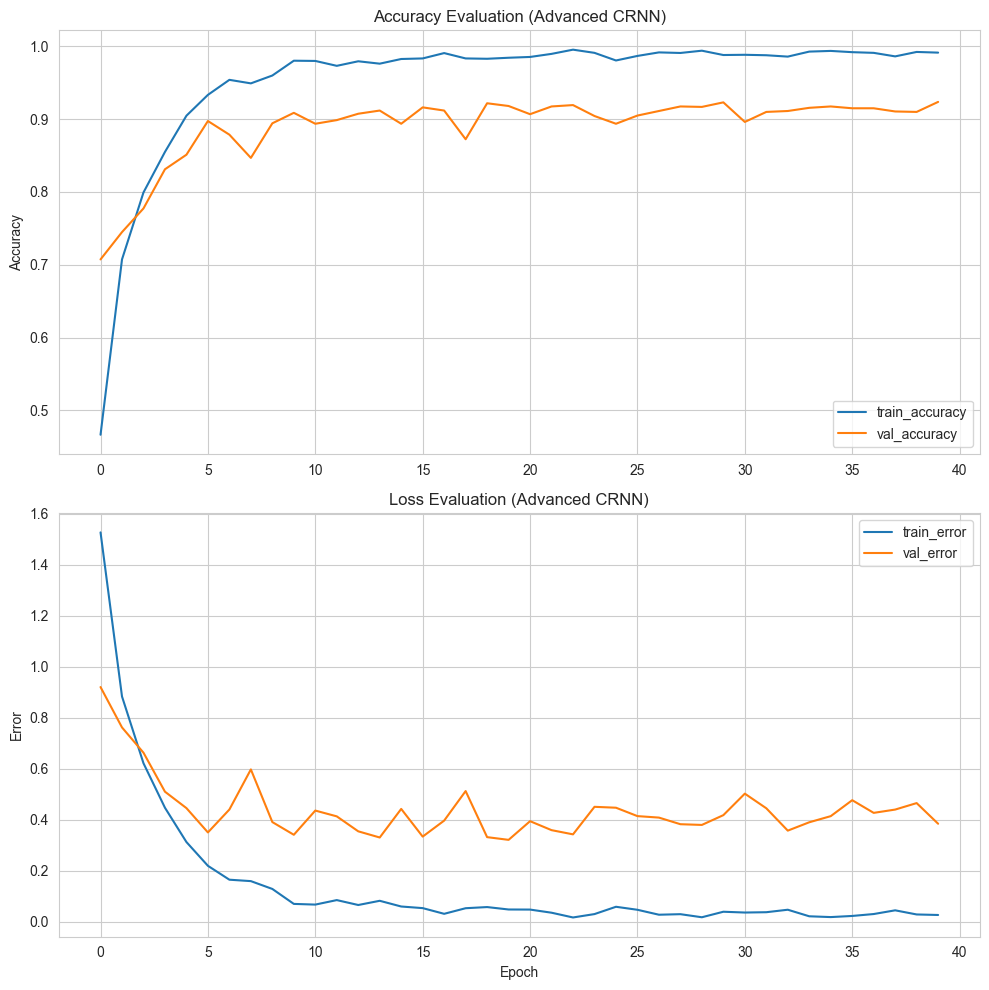

Testing Advanced Model: 100%|██████████| 63/63 [00:00<00:00, 97.36it/s]



Final Test Accuracy (Advanced CRNN): 0.9274


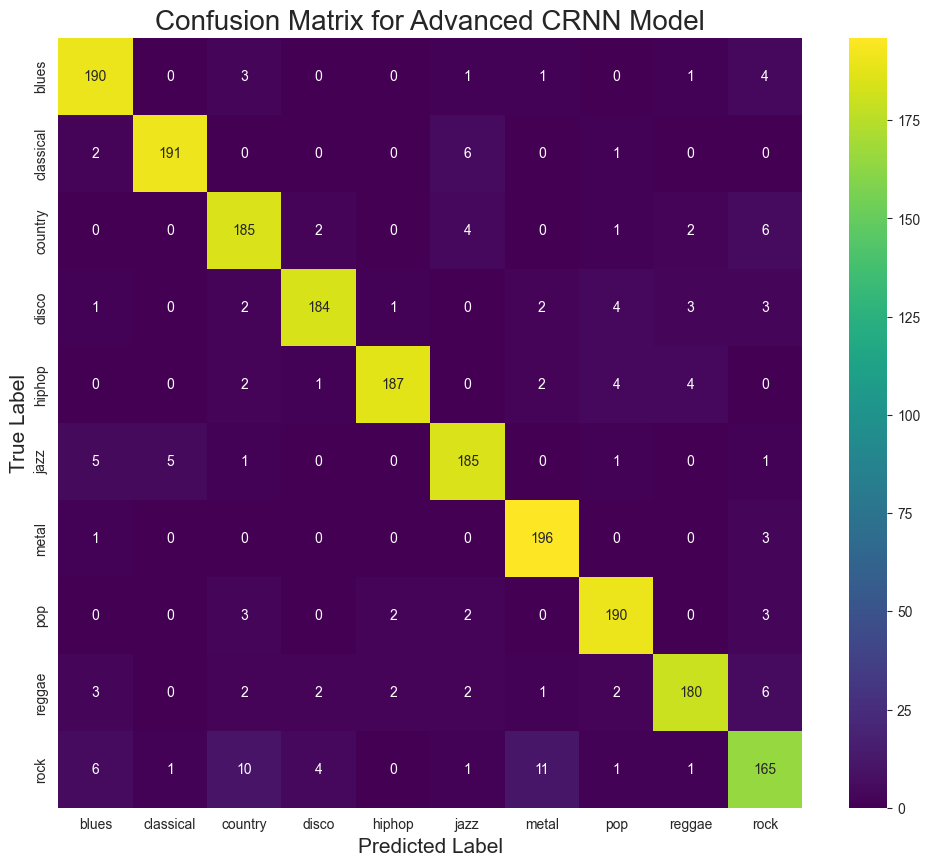

In [19]:
# --- 4. Final Evaluation ---
print("\n--- Evaluating Advanced CRNN Model ---")
adv_model.load_state_dict(torch.load('best_advanced_crnn_model.pth'))
adv_model.eval()

# Plot history
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    axs[0].plot(history["train_acc"], label="train_accuracy")
    axs[0].plot(history["val_acc"], label="val_accuracy")
    axs[0].set_ylabel("Accuracy"); axs[0].legend(loc="lower right"); axs[0].set_title("Accuracy Evaluation (Advanced CRNN)")
    axs[1].plot(history["train_loss"], label="train_error")
    axs[1].plot(history["val_loss"], label="val_error")
    axs[1].set_ylabel("Error"); axs[1].set_xlabel("Epoch"); axs[1].legend(loc="upper right"); axs[1].set_title("Loss Evaluation (Advanced CRNN)")
    plt.tight_layout(); plt.show()

plot_history(history_adv)

# Evaluate on test set
test_loss, correct_predictions, total_samples = 0.0, 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing Advanced Model"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = adv_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_test_acc = correct_predictions / total_samples
print(f"\nFinal Test Accuracy (Advanced CRNN): {final_test_acc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=genres, yticklabels=genres, cmap='viridis')
plt.title('Confusion Matrix for Advanced CRNN Model', fontsize=20)
plt.ylabel('True Label', fontsize=15)
plt.xlabel('Predicted Label', fontsize=15)
plt.show()

In [20]:
# =============================================================================
# Pipeline 2: Representation Learning with an Autoencoder
# =============================================================================

# ---
# ### **Part 1: Setup and Data Loading**
# ---

import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths
JSON_PATH = "data_segments.json"

Using device: cuda


In [21]:
# Custom Dataset class 
class GTZANDataset(Dataset):
    def __init__(self, X, y, normalize=False, X_min=None, X_max=None):
        """
        X: numpy array of data
        y: numpy array of labels
        normalize: whether to normalize the data
        X_min, X_max: normalization statistics from training set
        """
        if normalize:
            if X_min is None or X_max is None:
                # Only happens for training set - calculate stats
                X_min = X.min()
                X_max = X.max()
                print(f"Calculating normalization stats - Min: {X_min:.6f}, Max: {X_max:.6f}")
            
            # Apply normalization using provided (or calculated) stats
            X = (X - X_min) / (X_max - X_min + 1e-8)
            
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.tensor(y, dtype=torch.long)
        
        # Store for later use
        self.X_min = X_min
        self.X_max = X_max

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Load the base data
with open(JSON_PATH, "r") as fp:
    data = json.load(fp)
X = np.array(data["mel_spectrograms"])[..., np.newaxis]
y = np.array(data["labels"])
genres = data["mapping"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify=y_train)

# Calculate normalization statistics from TRAINING DATA ONLY
X_train_min = X_train.min()
X_train_max = X_train.max()

# Normalize using training statistics
X_train_norm = (X_train - X_train_min) / (X_train_max - X_train_min + 1e-8)
ae_dataset = torch.tensor(X_train_norm, dtype=torch.float32).permute(0, 3, 1, 2)
ae_loader = DataLoader(ae_dataset, batch_size=32, shuffle=True)

print(f"Normalization stats - Min: {X_train_min:.6f}, Max: {X_train_max:.6f}")

print("Data prepared for Autoencoder and Classifier training.")

Normalization stats - Min: -80.000000, Max: 0.000004
Data prepared for Autoencoder and Classifier training.


In [22]:
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        
        # --- Encoder ---
        # Input: (batch, 1, 128, 130)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # -> (batch, 16, 64, 65)
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> (batch, 32, 32, 33)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> (batch, 64, 16, 17)
            nn.ReLU()
        )
        
        # --- Decoder ---
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        # Crop or pad to match input dimensions exactly
        if decoded.shape[2] != height or decoded.shape[3] != width:
            decoded = decoded[:, :, :height, :width]
        
        return decoded

In [23]:
# Test the autoencoder dimensions
model_ae = ConvolutionalAutoencoder().to(device)
test_input = torch.randn(4, 1, 128, 130).to(device)
test_output = model_ae(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
assert test_input.shape == test_output.shape, "Input and output shapes must match"
print("Dimension check passed")

Input shape: torch.Size([4, 1, 128, 130])
Output shape: torch.Size([4, 1, 128, 130])
Dimension check passed


In [44]:
print(model_ae)

DeepBottleneckAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=18432, out_features=512, bias=True)
    (14): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=18432, bias=True)
    (1): ReLU

In [24]:
# Training Loop for the Autoencoder
AUTOENCODER_PATH = "autoencoder.pth"
if not os.path.exists(AUTOENCODER_PATH):
    print("Training Autoencoder...")
    model_ae = ConvolutionalAutoencoder().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_ae.parameters(), lr=1e-3)
    
    num_epochs = 50 
    for epoch in range(num_epochs):
        running_loss = 0.0
        pbar = tqdm(ae_loader, desc=f"AE Epoch {epoch+1}/{num_epochs}")
        for data_batch in pbar:
            inputs = data_batch.to(device) 
            
            optimizer.zero_grad()
            outputs = model_ae(inputs)
            loss = criterion(outputs, inputs) 
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            pbar.set_postfix({'loss': loss.item()})
            
        epoch_loss = running_loss / len(ae_loader.dataset)
        print(f"Epoch {epoch+1}, Autoencoder Loss: {epoch_loss:.6f}")
    
    torch.save(model_ae.state_dict(), AUTOENCODER_PATH)
    print(f"Autoencoder trained and saved to {AUTOENCODER_PATH}")
else:
    print(f"Loading pre-trained autoencoder from {AUTOENCODER_PATH}")

Training Autoencoder...


AE Epoch 1/50: 100%|██████████| 200/200 [00:02<00:00, 89.97it/s, loss=0.0029]  


Epoch 1, Autoencoder Loss: 0.007200


AE Epoch 2/50: 100%|██████████| 200/200 [00:01<00:00, 109.77it/s, loss=0.00272]


Epoch 2, Autoencoder Loss: 0.002413


AE Epoch 3/50: 100%|██████████| 200/200 [00:01<00:00, 111.11it/s, loss=0.00197]


Epoch 3, Autoencoder Loss: 0.001721


AE Epoch 4/50: 100%|██████████| 200/200 [00:01<00:00, 111.79it/s, loss=0.0018]  


Epoch 4, Autoencoder Loss: 0.001360


AE Epoch 5/50: 100%|██████████| 200/200 [00:01<00:00, 111.11it/s, loss=0.000862]


Epoch 5, Autoencoder Loss: 0.001195


AE Epoch 6/50: 100%|██████████| 200/200 [00:01<00:00, 113.51it/s, loss=0.000749]


Epoch 6, Autoencoder Loss: 0.000975


AE Epoch 7/50: 100%|██████████| 200/200 [00:01<00:00, 111.61it/s, loss=0.001]   


Epoch 7, Autoencoder Loss: 0.000882


AE Epoch 8/50: 100%|██████████| 200/200 [00:01<00:00, 113.64it/s, loss=0.00072] 


Epoch 8, Autoencoder Loss: 0.000864


AE Epoch 9/50: 100%|██████████| 200/200 [00:01<00:00, 111.36it/s, loss=0.000859]


Epoch 9, Autoencoder Loss: 0.000805


AE Epoch 10/50: 100%|██████████| 200/200 [00:01<00:00, 112.36it/s, loss=0.000726]


Epoch 10, Autoencoder Loss: 0.000715


AE Epoch 11/50: 100%|██████████| 200/200 [00:01<00:00, 113.25it/s, loss=0.0013]  


Epoch 11, Autoencoder Loss: 0.000768


AE Epoch 12/50: 100%|██████████| 200/200 [00:01<00:00, 113.31it/s, loss=0.000408]


Epoch 12, Autoencoder Loss: 0.000729


AE Epoch 13/50: 100%|██████████| 200/200 [00:01<00:00, 112.30it/s, loss=0.000815]


Epoch 13, Autoencoder Loss: 0.000629


AE Epoch 14/50: 100%|██████████| 200/200 [00:01<00:00, 113.51it/s, loss=0.000609]


Epoch 14, Autoencoder Loss: 0.000627


AE Epoch 15/50: 100%|██████████| 200/200 [00:01<00:00, 111.23it/s, loss=0.000527]


Epoch 15, Autoencoder Loss: 0.000591


AE Epoch 16/50: 100%|██████████| 200/200 [00:01<00:00, 113.51it/s, loss=0.000553]


Epoch 16, Autoencoder Loss: 0.000606


AE Epoch 17/50: 100%|██████████| 200/200 [00:01<00:00, 111.48it/s, loss=0.000428]


Epoch 17, Autoencoder Loss: 0.000532


AE Epoch 18/50: 100%|██████████| 200/200 [00:01<00:00, 112.84it/s, loss=0.000576]


Epoch 18, Autoencoder Loss: 0.000577


AE Epoch 19/50: 100%|██████████| 200/200 [00:01<00:00, 111.42it/s, loss=0.00112] 


Epoch 19, Autoencoder Loss: 0.000529


AE Epoch 20/50: 100%|██████████| 200/200 [00:01<00:00, 112.99it/s, loss=0.000332]


Epoch 20, Autoencoder Loss: 0.000509


AE Epoch 21/50: 100%|██████████| 200/200 [00:01<00:00, 110.99it/s, loss=0.000508]


Epoch 21, Autoencoder Loss: 0.000510


AE Epoch 22/50: 100%|██████████| 200/200 [00:01<00:00, 112.87it/s, loss=0.000355]


Epoch 22, Autoencoder Loss: 0.000523


AE Epoch 23/50: 100%|██████████| 200/200 [00:01<00:00, 110.99it/s, loss=0.000499]


Epoch 23, Autoencoder Loss: 0.000492


AE Epoch 24/50: 100%|██████████| 200/200 [00:01<00:00, 113.12it/s, loss=0.000698]


Epoch 24, Autoencoder Loss: 0.000452


AE Epoch 25/50: 100%|██████████| 200/200 [00:01<00:00, 111.36it/s, loss=0.000447]


Epoch 25, Autoencoder Loss: 0.000489


AE Epoch 26/50: 100%|██████████| 200/200 [00:01<00:00, 112.61it/s, loss=0.000599]


Epoch 26, Autoencoder Loss: 0.000484


AE Epoch 27/50: 100%|██████████| 200/200 [00:01<00:00, 112.68it/s, loss=0.000322]


Epoch 27, Autoencoder Loss: 0.000426


AE Epoch 28/50: 100%|██████████| 200/200 [00:01<00:00, 112.61it/s, loss=0.000522]


Epoch 28, Autoencoder Loss: 0.000427


AE Epoch 29/50: 100%|██████████| 200/200 [00:01<00:00, 112.68it/s, loss=0.00034] 


Epoch 29, Autoencoder Loss: 0.000427


AE Epoch 30/50: 100%|██████████| 200/200 [00:01<00:00, 111.30it/s, loss=0.00068] 


Epoch 30, Autoencoder Loss: 0.000435


AE Epoch 31/50: 100%|██████████| 200/200 [00:01<00:00, 111.05it/s, loss=0.00024] 


Epoch 31, Autoencoder Loss: 0.000390


AE Epoch 32/50: 100%|██████████| 200/200 [00:01<00:00, 110.74it/s, loss=0.000362]


Epoch 32, Autoencoder Loss: 0.000377


AE Epoch 33/50: 100%|██████████| 200/200 [00:01<00:00, 112.87it/s, loss=0.000293]


Epoch 33, Autoencoder Loss: 0.000389


AE Epoch 34/50: 100%|██████████| 200/200 [00:01<00:00, 111.05it/s, loss=0.000358]


Epoch 34, Autoencoder Loss: 0.000374


AE Epoch 35/50: 100%|██████████| 200/200 [00:01<00:00, 112.61it/s, loss=0.000397]


Epoch 35, Autoencoder Loss: 0.000391


AE Epoch 36/50: 100%|██████████| 200/200 [00:01<00:00, 111.36it/s, loss=0.000268]


Epoch 36, Autoencoder Loss: 0.000392


AE Epoch 37/50: 100%|██████████| 200/200 [00:01<00:00, 112.74it/s, loss=0.000238]


Epoch 37, Autoencoder Loss: 0.000348


AE Epoch 38/50: 100%|██████████| 200/200 [00:01<00:00, 111.05it/s, loss=0.000586]


Epoch 38, Autoencoder Loss: 0.000364


AE Epoch 39/50: 100%|██████████| 200/200 [00:01<00:00, 112.87it/s, loss=0.000224]


Epoch 39, Autoencoder Loss: 0.000320


AE Epoch 40/50: 100%|██████████| 200/200 [00:01<00:00, 110.93it/s, loss=0.000282]


Epoch 40, Autoencoder Loss: 0.000367


AE Epoch 41/50: 100%|██████████| 200/200 [00:01<00:00, 112.93it/s, loss=0.000396]


Epoch 41, Autoencoder Loss: 0.000320


AE Epoch 42/50: 100%|██████████| 200/200 [00:01<00:00, 112.87it/s, loss=0.000326]


Epoch 42, Autoencoder Loss: 0.000341


AE Epoch 43/50: 100%|██████████| 200/200 [00:01<00:00, 111.05it/s, loss=0.000232]


Epoch 43, Autoencoder Loss: 0.000305


AE Epoch 44/50: 100%|██████████| 200/200 [00:01<00:00, 113.06it/s, loss=0.000267]


Epoch 44, Autoencoder Loss: 0.000375


AE Epoch 45/50: 100%|██████████| 200/200 [00:01<00:00, 110.50it/s, loss=0.000455]


Epoch 45, Autoencoder Loss: 0.000282


AE Epoch 46/50: 100%|██████████| 200/200 [00:01<00:00, 112.74it/s, loss=0.000282]


Epoch 46, Autoencoder Loss: 0.000286


AE Epoch 47/50: 100%|██████████| 200/200 [00:01<00:00, 110.38it/s, loss=0.000326]


Epoch 47, Autoencoder Loss: 0.000278


AE Epoch 48/50: 100%|██████████| 200/200 [00:01<00:00, 112.80it/s, loss=0.000469]


Epoch 48, Autoencoder Loss: 0.000279


AE Epoch 49/50: 100%|██████████| 200/200 [00:01<00:00, 111.30it/s, loss=0.000691]


Epoch 49, Autoencoder Loss: 0.000288


AE Epoch 50/50: 100%|██████████| 200/200 [00:01<00:00, 112.49it/s, loss=0.000253]

Epoch 50, Autoencoder Loss: 0.000347
Autoencoder trained and saved to autoencoder.pth


Visualizing reconstructions...


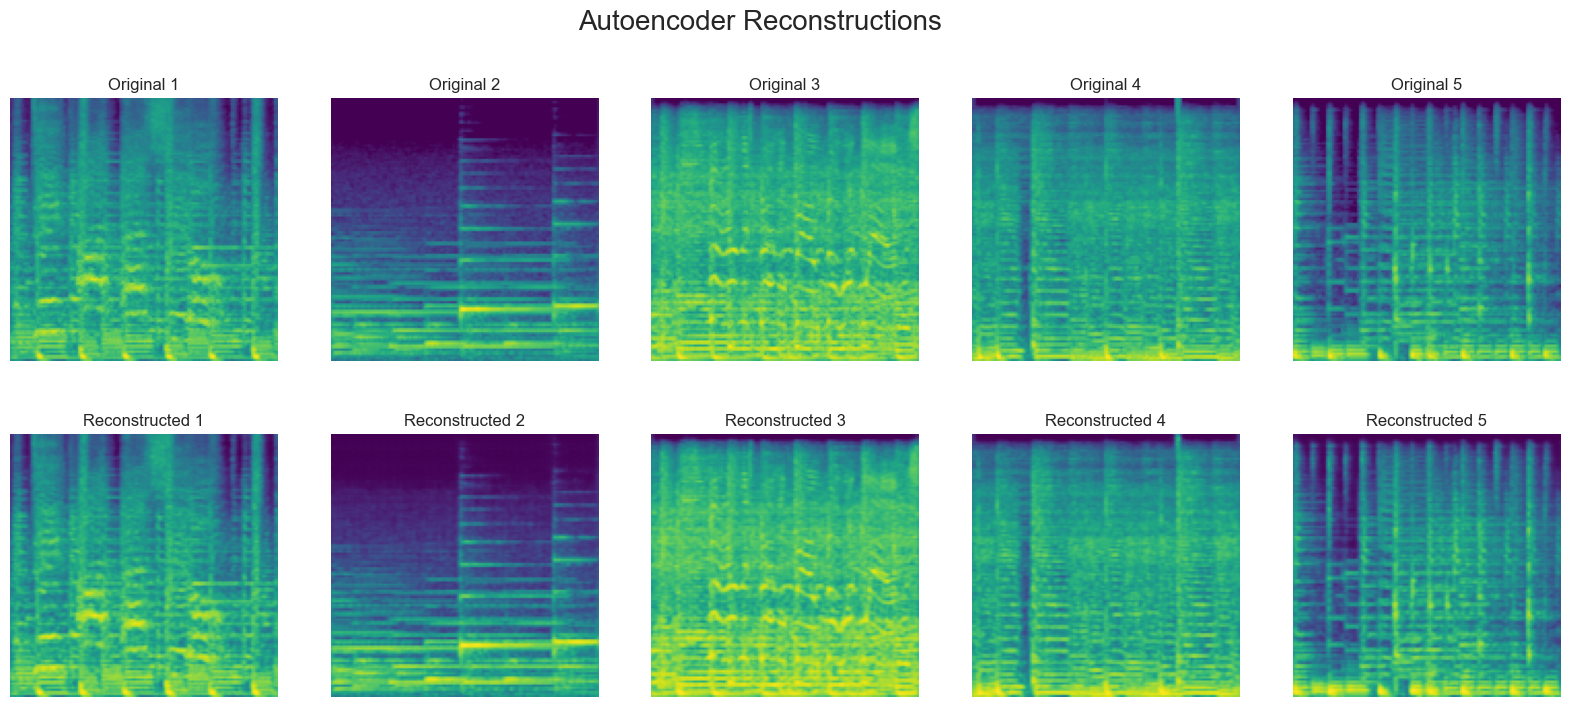

In [25]:
# ---
# ### **Part 3: Visualize Autoencoder Reconstructions**
# ---

print("Visualizing reconstructions...")
model_ae = ConvolutionalAutoencoder()
model_ae.load_state_dict(torch.load(AUTOENCODER_PATH))
model_ae.to(device)
model_ae.eval()

# Get a few examples from the test set
test_dataset_norm = GTZANDataset(X_test, y_test, normalize=True, 
                                  X_min=X_train_min, X_max=X_train_max)
test_loader_norm = DataLoader(test_dataset_norm, batch_size=5, shuffle=True)
original_images, _ = next(iter(test_loader_norm))

with torch.no_grad():
    reconstructed_images = model_ae(original_images.to(device)).cpu()

# Plot them
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(5):
    # Original
    axes[0, i].imshow(original_images[i].squeeze(), cmap='viridis', origin='lower')
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')
    
    # Reconstructed
    axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='viridis', origin='lower')
    axes[1, i].set_title(f"Reconstructed {i+1}")
    axes[1, i].axis('off')

plt.suptitle("Autoencoder Reconstructions", fontsize=20)
plt.show()

In [26]:
# ---
# ### **Part 4: Build and Train the Classifier**
# ---
# Now we build the final classifier. We will:
# 1. Load the trained autoencoder.
# 2. Extract only the encoder part.
# 3. Freeze the encoder's weights so they don't change.
# 4. Add a new, small classification head.
# 5. Train only the new classification head.

class GenreClassifier(nn.Module):
    def __init__(self, num_genres=10):
        super(GenreClassifier, self).__init__()
        
        # 1. Load the full autoencoder
        base_autoencoder = ConvolutionalAutoencoder()
        base_autoencoder.load_state_dict(torch.load(AUTOENCODER_PATH))
        
        # 2. Extract the encoder
        self.encoder = base_autoencoder.encoder
        
        # 3. Freeze its weights
        for param in self.encoder.parameters():
            param.requires_grad = False
            
        # 4. Add a new classifier head
        # The flattened size is 64 channels * 16 height * 17 width
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 17, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_genres)
        )

    def forward(self, x):
        features = self.encoder(x)
        output = self.classifier(features)
        return output

# --- Training the Classifier ---
# We use the UN-NORMALIZED data for the classifier
train_dataset_cls = GTZANDataset(X_train, y_train, normalize=True)
val_dataset_cls = GTZANDataset(X_val, y_val, normalize=True, 
                                X_min=train_dataset_cls.X_min, 
                                X_max=train_dataset_cls.X_max)
train_loader_cls = DataLoader(train_dataset_cls, batch_size=32, shuffle=True)
val_loader_cls = DataLoader(val_dataset_cls, batch_size=32)

model_cls = GenreClassifier(num_genres=len(genres)).to(device)

# IMPORTANT: We only pass the parameters of the *unfrozen* part to the optimizer
optimizer = optim.Adam(model_cls.classifier.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

print("\nTraining the classifier head...")
# Re-use the training loop logic from our CRNN model
best_val_loss = float('inf')
epochs_no_improve = 0
history_cls = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(100):
    model_cls.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader_cls, desc=f"CLF Epoch {epoch+1}/100 [Train]")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_cls(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, pred = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        pbar.set_postfix({'loss': loss.item(), 'acc': (pred == labels).sum().item()/labels.size(0)})
    
    history_cls['train_loss'].append(running_loss / total)
    history_cls['train_acc'].append(correct / total)

    # Validation
    model_cls.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader_cls:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_cls(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
    
    epoch_val_loss = val_loss / total
    history_cls['val_loss'].append(epoch_val_loss)
    history_cls['val_acc'].append(correct / total)
    
    print(f"Epoch {epoch+1} -> Val Loss: {epoch_val_loss:.4f}, Val Acc: {correct/total:.4f}")
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model_cls.state_dict(), 'best_classifier_model.pth')
    else:
        epochs_no_improve += 1
    if epochs_no_improve >= 10:
        print("Early stopping.")
        break

Calculating normalization stats - Min: -80.000000, Max: 0.000004

Training the classifier head...


CLF Epoch 1/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 139.81it/s, loss=2.16, acc=0.2]   


Epoch 1 -> Val Loss: 2.0386, Val Acc: 0.2464


CLF Epoch 2/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 178.41it/s, loss=2.03, acc=0.24]  


Epoch 2 -> Val Loss: 1.8881, Val Acc: 0.3408


CLF Epoch 3/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 173.91it/s, loss=2.13, acc=0.24]  


Epoch 3 -> Val Loss: 1.7859, Val Acc: 0.3965


CLF Epoch 4/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 185.87it/s, loss=1.78, acc=0.44] 


Epoch 4 -> Val Loss: 1.7809, Val Acc: 0.3640


CLF Epoch 5/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 176.21it/s, loss=1.92, acc=0.16] 


Epoch 5 -> Val Loss: 1.7182, Val Acc: 0.4115


CLF Epoch 6/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 184.16it/s, loss=1.74, acc=0.48]  


Epoch 6 -> Val Loss: 1.6554, Val Acc: 0.4334


CLF Epoch 7/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 184.16it/s, loss=1.62, acc=0.44] 


Epoch 7 -> Val Loss: 1.6231, Val Acc: 0.4503


CLF Epoch 8/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 178.89it/s, loss=1.85, acc=0.36] 


Epoch 8 -> Val Loss: 1.6315, Val Acc: 0.4259


CLF Epoch 9/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 184.50it/s, loss=1.55, acc=0.44] 


Epoch 9 -> Val Loss: 1.5750, Val Acc: 0.4603


CLF Epoch 10/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 178.09it/s, loss=1.84, acc=0.28] 


Epoch 10 -> Val Loss: 1.5382, Val Acc: 0.4490


CLF Epoch 11/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 184.33it/s, loss=1.81, acc=0.28] 


Epoch 11 -> Val Loss: 1.5202, Val Acc: 0.4697


CLF Epoch 12/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 170.79it/s, loss=2.02, acc=0.44] 


Epoch 12 -> Val Loss: 1.4899, Val Acc: 0.4728


CLF Epoch 13/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 181.98it/s, loss=1.61, acc=0.4]  


Epoch 13 -> Val Loss: 1.4518, Val Acc: 0.4872


CLF Epoch 14/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 183.82it/s, loss=1.79, acc=0.32] 


Epoch 14 -> Val Loss: 1.4673, Val Acc: 0.4790


CLF Epoch 15/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 175.66it/s, loss=1.59, acc=0.48] 


Epoch 15 -> Val Loss: 1.4028, Val Acc: 0.5022


CLF Epoch 16/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 185.53it/s, loss=1.51, acc=0.56] 


Epoch 16 -> Val Loss: 1.4042, Val Acc: 0.5153


CLF Epoch 17/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 179.37it/s, loss=1.62, acc=0.32] 


Epoch 17 -> Val Loss: 1.4091, Val Acc: 0.5147


CLF Epoch 18/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 186.31it/s, loss=1.68, acc=0.28] 


Epoch 18 -> Val Loss: 1.4199, Val Acc: 0.5197


CLF Epoch 19/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 186.22it/s, loss=1.56, acc=0.32] 


Epoch 19 -> Val Loss: 1.3777, Val Acc: 0.5203


CLF Epoch 20/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 174.07it/s, loss=1.5, acc=0.4]   


Epoch 20 -> Val Loss: 1.3672, Val Acc: 0.5141


CLF Epoch 21/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 185.01it/s, loss=1.3, acc=0.52]  


Epoch 21 -> Val Loss: 1.3550, Val Acc: 0.5241


CLF Epoch 22/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 176.99it/s, loss=1.77, acc=0.44] 


Epoch 22 -> Val Loss: 1.3539, Val Acc: 0.5216


CLF Epoch 23/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 182.48it/s, loss=1.76, acc=0.32] 


Epoch 23 -> Val Loss: 1.3346, Val Acc: 0.5260


CLF Epoch 24/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 184.50it/s, loss=1.48, acc=0.44] 


Epoch 24 -> Val Loss: 1.2854, Val Acc: 0.5447


CLF Epoch 25/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 176.83it/s, loss=1.73, acc=0.36] 


Epoch 25 -> Val Loss: 1.2884, Val Acc: 0.5372


CLF Epoch 26/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 185.36it/s, loss=1.48, acc=0.44] 


Epoch 26 -> Val Loss: 1.3211, Val Acc: 0.5391


CLF Epoch 27/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 184.50it/s, loss=1.37, acc=0.52] 


Epoch 27 -> Val Loss: 1.3072, Val Acc: 0.5472


CLF Epoch 28/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 177.46it/s, loss=1.82, acc=0.28] 


Epoch 28 -> Val Loss: 1.2997, Val Acc: 0.5478


CLF Epoch 29/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 184.16it/s, loss=1.43, acc=0.4]  


Epoch 29 -> Val Loss: 1.2798, Val Acc: 0.5385


CLF Epoch 30/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 177.46it/s, loss=1.64, acc=0.4]  


Epoch 30 -> Val Loss: 1.3233, Val Acc: 0.5604


CLF Epoch 31/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 183.65it/s, loss=1.39, acc=0.32]  


Epoch 31 -> Val Loss: 1.2769, Val Acc: 0.5285


CLF Epoch 32/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 183.82it/s, loss=1.48, acc=0.4]  


Epoch 32 -> Val Loss: 1.2454, Val Acc: 0.5816


CLF Epoch 33/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 177.30it/s, loss=1.28, acc=0.48] 


Epoch 33 -> Val Loss: 1.2743, Val Acc: 0.5760


CLF Epoch 34/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 183.32it/s, loss=1.37, acc=0.44] 


Epoch 34 -> Val Loss: 1.2881, Val Acc: 0.5729


CLF Epoch 35/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 183.99it/s, loss=1.6, acc=0.4]   


Epoch 35 -> Val Loss: 1.2229, Val Acc: 0.5797


CLF Epoch 36/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 178.57it/s, loss=1.3, acc=0.4]   


Epoch 36 -> Val Loss: 1.2546, Val Acc: 0.5403


CLF Epoch 37/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 179.37it/s, loss=1.64, acc=0.48]  


Epoch 37 -> Val Loss: 1.2348, Val Acc: 0.5729


CLF Epoch 38/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 173.91it/s, loss=1.62, acc=0.36]  


Epoch 38 -> Val Loss: 1.2229, Val Acc: 0.5710


CLF Epoch 39/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 181.32it/s, loss=1.46, acc=0.36] 


Epoch 39 -> Val Loss: 1.2559, Val Acc: 0.5616


CLF Epoch 40/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 182.32it/s, loss=1.2, acc=0.56]   


Epoch 40 -> Val Loss: 1.2131, Val Acc: 0.5560


CLF Epoch 41/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 175.59it/s, loss=1.03, acc=0.64] 


Epoch 41 -> Val Loss: 1.2484, Val Acc: 0.5541


CLF Epoch 42/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 182.32it/s, loss=1.3, acc=0.48]   


Epoch 42 -> Val Loss: 1.2153, Val Acc: 0.5779


CLF Epoch 43/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 181.65it/s, loss=1.27, acc=0.44]  


Epoch 43 -> Val Loss: 1.2121, Val Acc: 0.5916


CLF Epoch 44/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 174.37it/s, loss=1.44, acc=0.44]  


Epoch 44 -> Val Loss: 1.2349, Val Acc: 0.5704


CLF Epoch 45/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 182.65it/s, loss=1.38, acc=0.48]  


Epoch 45 -> Val Loss: 1.1981, Val Acc: 0.5691


CLF Epoch 46/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 181.32it/s, loss=1.14, acc=0.56]  


Epoch 46 -> Val Loss: 1.1695, Val Acc: 0.5860


CLF Epoch 47/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 174.98it/s, loss=1.02, acc=0.56] 


Epoch 47 -> Val Loss: 1.1923, Val Acc: 0.5922


CLF Epoch 48/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 182.15it/s, loss=1.25, acc=0.6]   


Epoch 48 -> Val Loss: 1.1698, Val Acc: 0.5885


CLF Epoch 49/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 176.52it/s, loss=1.22, acc=0.68]  


Epoch 49 -> Val Loss: 1.1595, Val Acc: 0.5841


CLF Epoch 50/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 181.16it/s, loss=1.1, acc=0.64]   


Epoch 50 -> Val Loss: 1.2354, Val Acc: 0.5572


CLF Epoch 51/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 182.15it/s, loss=1.3, acc=0.52]   


Epoch 51 -> Val Loss: 1.2226, Val Acc: 0.5585


CLF Epoch 52/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 175.59it/s, loss=1.51, acc=0.44]  


Epoch 52 -> Val Loss: 1.1553, Val Acc: 0.5910


CLF Epoch 53/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 182.65it/s, loss=0.989, acc=0.64] 


Epoch 53 -> Val Loss: 1.2324, Val Acc: 0.5460


CLF Epoch 54/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 180.18it/s, loss=1.31, acc=0.4]   


Epoch 54 -> Val Loss: 1.2073, Val Acc: 0.5735


CLF Epoch 55/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 175.90it/s, loss=1.06, acc=0.64]  


Epoch 55 -> Val Loss: 1.1739, Val Acc: 0.5879


CLF Epoch 56/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 181.98it/s, loss=1.21, acc=0.52]  


Epoch 56 -> Val Loss: 1.1798, Val Acc: 0.5835


CLF Epoch 57/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 176.37it/s, loss=1.37, acc=0.48]  


Epoch 57 -> Val Loss: 1.1678, Val Acc: 0.5841


CLF Epoch 58/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 181.49it/s, loss=1.4, acc=0.56]   


Epoch 58 -> Val Loss: 1.1528, Val Acc: 0.5916


CLF Epoch 59/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 181.16it/s, loss=1.23, acc=0.52]  


Epoch 59 -> Val Loss: 1.1812, Val Acc: 0.5616


CLF Epoch 60/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 174.83it/s, loss=0.783, acc=0.68] 


Epoch 60 -> Val Loss: 1.1514, Val Acc: 0.5872


CLF Epoch 61/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 182.15it/s, loss=1.46, acc=0.52]  


Epoch 61 -> Val Loss: 1.1984, Val Acc: 0.5922


CLF Epoch 62/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 176.06it/s, loss=0.981, acc=0.6]  


Epoch 62 -> Val Loss: 1.1524, Val Acc: 0.5941


CLF Epoch 63/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 181.82it/s, loss=0.891, acc=0.64] 


Epoch 63 -> Val Loss: 1.1594, Val Acc: 0.5891


CLF Epoch 64/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 180.51it/s, loss=0.976, acc=0.56] 


Epoch 64 -> Val Loss: 1.2135, Val Acc: 0.6004


CLF Epoch 65/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 176.84it/s, loss=1.24, acc=0.44]  


Epoch 65 -> Val Loss: 1.2176, Val Acc: 0.5635


CLF Epoch 66/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 181.65it/s, loss=1, acc=0.56]     


Epoch 66 -> Val Loss: 1.1908, Val Acc: 0.5754


CLF Epoch 67/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 174.98it/s, loss=1.02, acc=0.56]  


Epoch 67 -> Val Loss: 1.1614, Val Acc: 0.6048


CLF Epoch 68/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 181.00it/s, loss=1.56, acc=0.32]  


Epoch 68 -> Val Loss: 1.1310, Val Acc: 0.6023


CLF Epoch 69/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 180.67it/s, loss=1.64, acc=0.4]   


Epoch 69 -> Val Loss: 1.1745, Val Acc: 0.5935


CLF Epoch 70/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 174.37it/s, loss=1.16, acc=0.48]  


Epoch 70 -> Val Loss: 1.1692, Val Acc: 0.5879


CLF Epoch 71/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 181.32it/s, loss=1.21, acc=0.44]  


Epoch 71 -> Val Loss: 1.1787, Val Acc: 0.5922


CLF Epoch 72/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 182.65it/s, loss=1.14, acc=0.52]  


Epoch 72 -> Val Loss: 1.1474, Val Acc: 0.5941


CLF Epoch 73/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 176.37it/s, loss=1.11, acc=0.64]  


Epoch 73 -> Val Loss: 1.1531, Val Acc: 0.5941


CLF Epoch 74/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 181.49it/s, loss=1, acc=0.6]      


Epoch 74 -> Val Loss: 1.1835, Val Acc: 0.5679


CLF Epoch 75/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 175.28it/s, loss=1.04, acc=0.6]   


Epoch 75 -> Val Loss: 1.1325, Val Acc: 0.6004


CLF Epoch 76/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 182.82it/s, loss=1, acc=0.56]     


Epoch 76 -> Val Loss: 1.1692, Val Acc: 0.5966


CLF Epoch 77/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 182.48it/s, loss=0.942, acc=0.56] 


Epoch 77 -> Val Loss: 1.1226, Val Acc: 0.6129


CLF Epoch 78/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 119.19it/s, loss=1.04, acc=0.68]  


Epoch 78 -> Val Loss: 1.2346, Val Acc: 0.5553


CLF Epoch 79/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 144.72it/s, loss=0.786, acc=0.8]  


Epoch 79 -> Val Loss: 1.1854, Val Acc: 0.5810


CLF Epoch 80/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 141.84it/s, loss=1.32, acc=0.52]  


Epoch 80 -> Val Loss: 1.1792, Val Acc: 0.5766


CLF Epoch 81/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 147.93it/s, loss=0.91, acc=0.68]  


Epoch 81 -> Val Loss: 1.1670, Val Acc: 0.6048


CLF Epoch 82/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 155.04it/s, loss=1, acc=0.6]      


Epoch 82 -> Val Loss: 1.2325, Val Acc: 0.5779


CLF Epoch 83/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 170.07it/s, loss=0.869, acc=0.52] 


Epoch 83 -> Val Loss: 1.1867, Val Acc: 0.6029


CLF Epoch 84/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 152.09it/s, loss=1.18, acc=0.52]  


Epoch 84 -> Val Loss: 1.1721, Val Acc: 0.5904


CLF Epoch 85/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 169.06it/s, loss=1.15, acc=0.56]  


Epoch 85 -> Val Loss: 1.1596, Val Acc: 0.5910


CLF Epoch 86/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 175.13it/s, loss=1.01, acc=0.64]  


Epoch 86 -> Val Loss: 1.1794, Val Acc: 0.6110


CLF Epoch 87/100 [Train]: 100%|██████████| 200/200 [00:01<00:00, 159.24it/s, loss=1.09, acc=0.48]  


Epoch 87 -> Val Loss: 1.1658, Val Acc: 0.5941
Early stopping.



Plotting classifier training history...


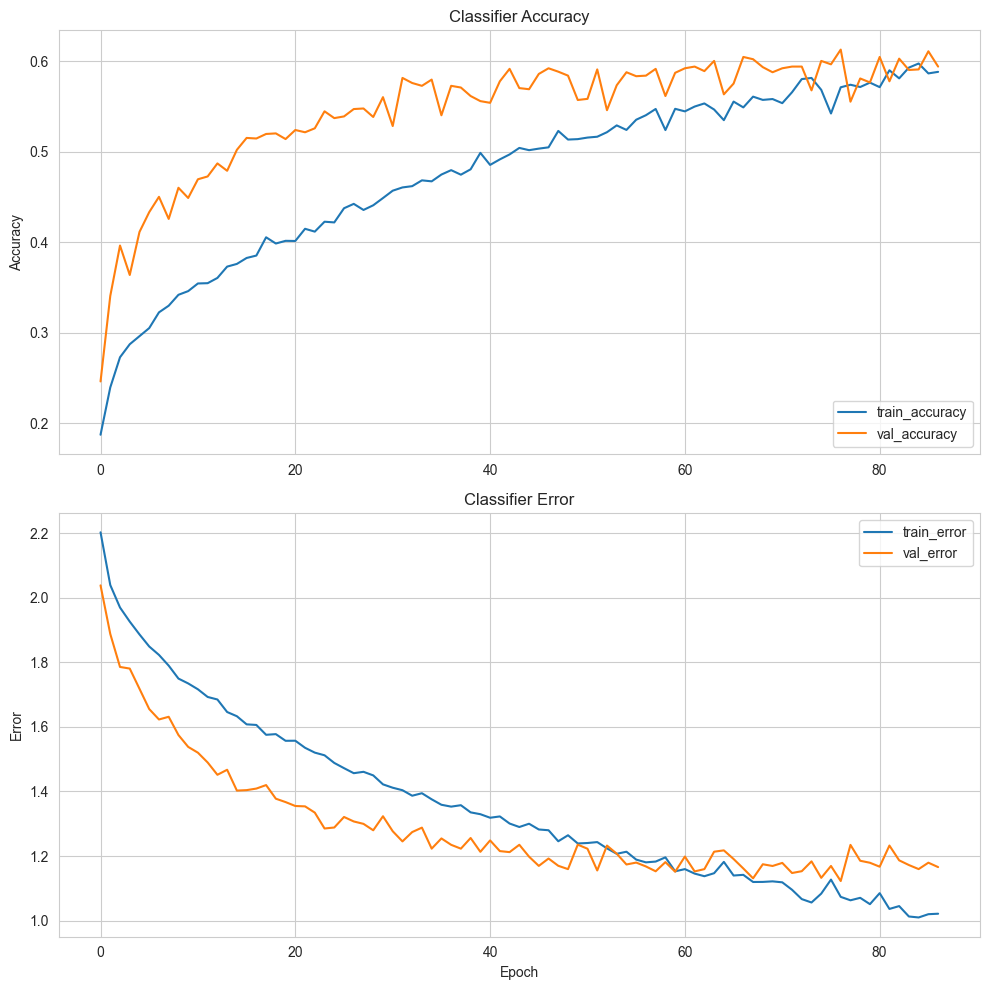


Evaluating classifier on the test set...


100%|██████████| 63/63 [00:00<00:00, 302.88it/s]



--- Classification Report ---
              precision    recall  f1-score   support

       blues       0.63      0.73      0.68       200
   classical       0.78      0.85      0.81       200
     country       0.63      0.39      0.48       200
       disco       0.43      0.42      0.43       200
      hiphop       0.48      0.59      0.53       200
        jazz       0.59      0.51      0.55       198
       metal       0.68      0.92      0.78       200
         pop       0.72      0.67      0.69       200
      reggae       0.43      0.42      0.43       200
        rock       0.49      0.39      0.43       200

    accuracy                           0.59      1998
   macro avg       0.59      0.59      0.58      1998
weighted avg       0.59      0.59      0.58      1998



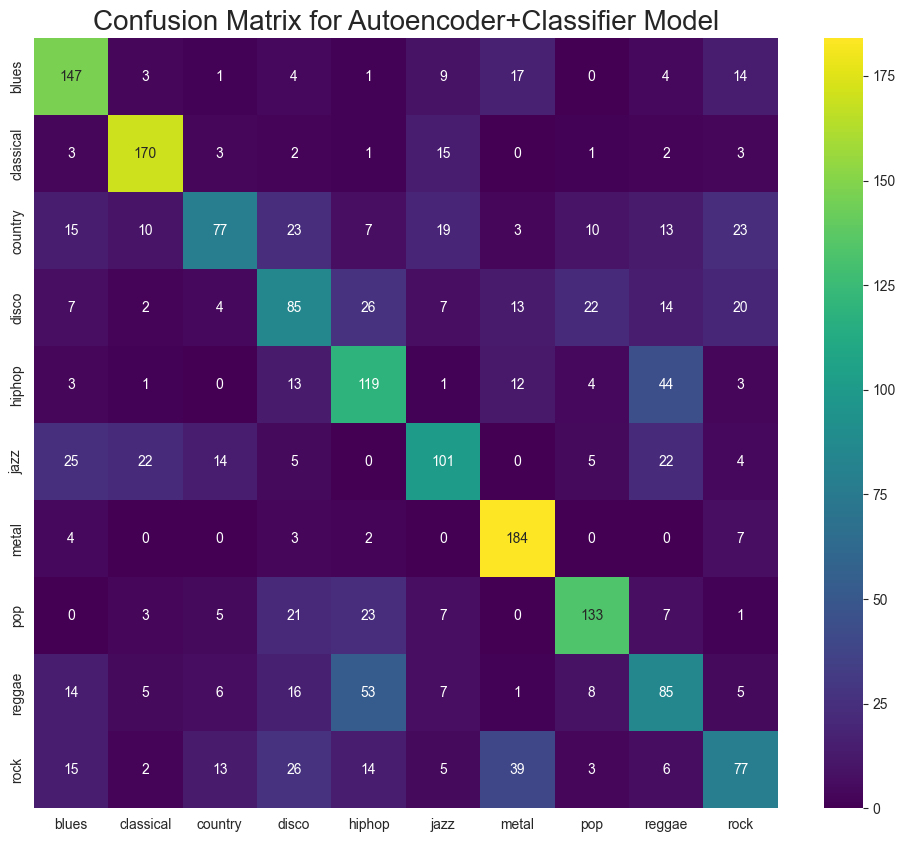

In [27]:
# ---
# ### **Part 5: Final Evaluation and Latent Space Visualization**
# ---

# Load the best performing classifier
model_cls.load_state_dict(torch.load('best_classifier_model.pth'))
model_cls.eval()

# Plot history
print("\nPlotting classifier training history...")
def plot_history_pytorch(history):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    axs[0].plot(history["train_acc"], label="train_accuracy")
    axs[0].plot(history["val_acc"], label="val_accuracy")
    axs[0].set_ylabel("Accuracy"); axs[0].legend(loc="lower right"); axs[0].set_title("Classifier Accuracy")
    axs[1].plot(history["train_loss"], label="train_error")
    axs[1].plot(history["val_loss"], label="val_error")
    axs[1].set_ylabel("Error"); axs[1].set_xlabel("Epoch"); axs[1].legend(loc="upper right"); axs[1].set_title("Classifier Error")
    plt.tight_layout(); plt.show()
plot_history_pytorch(history_cls)

# Evaluate on the test set and generate confusion matrix
print("\nEvaluating classifier on the test set...")
test_dataset_cls = GTZANDataset(X_test, y_test, normalize=True,
                                X_min=X_train_min, X_max=X_train_max)
test_loader_cls = DataLoader(test_dataset_cls, batch_size=32)

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader_cls):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_cls(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=genres))

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=genres, yticklabels=genres, cmap='viridis')
plt.title('Confusion Matrix for Autoencoder+Classifier Model', fontsize=20)
plt.show()


Generating t-SNE plot of the latent space...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1998 samples in 0.023s...
[t-SNE] Computed neighbors for 1998 samples in 6.912s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1998
[t-SNE] Computed conditional probabilities for sample 1998 / 1998
[t-SNE] Mean sigma: 25.257556
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.523026
[t-SNE] KL divergence after 1000 iterations: 1.714332


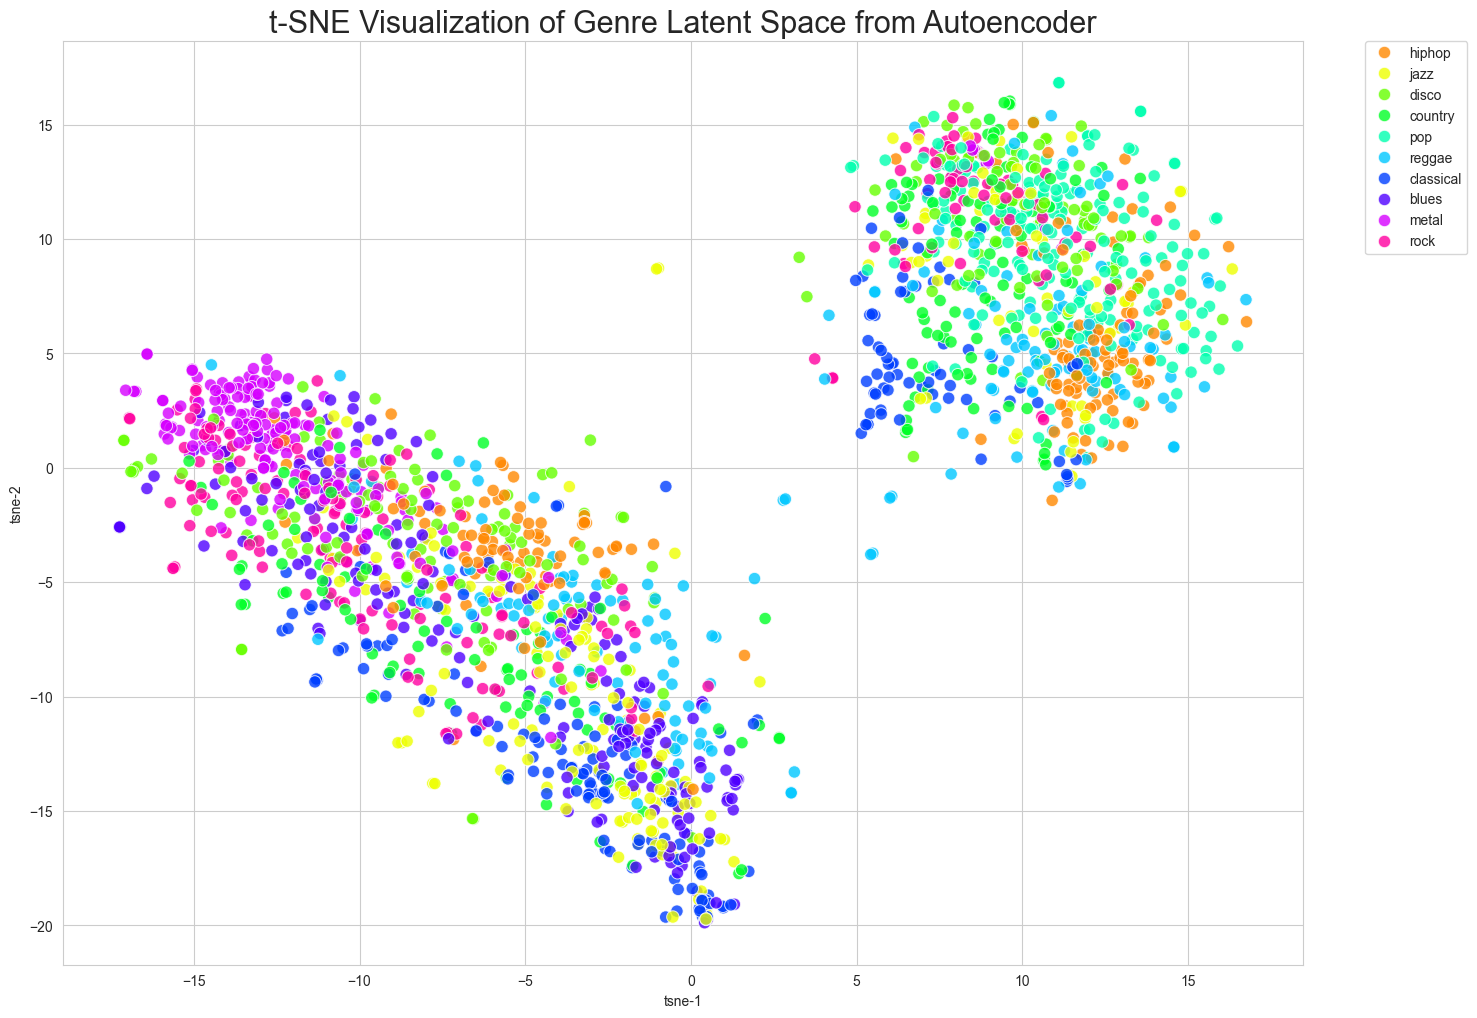

In [28]:
# ---
# #### Visualize the Latent Space with t-SNE
# ---

print("\nGenerating t-SNE plot of the latent space...")
# Use a subset of the test data for speed
tsne_dataset = GTZANDataset(X_test, y_test, normalize=True,
                            X_min=X_train_min, X_max=X_train_max)
tsne_loader = DataLoader(tsne_dataset, batch_size=2000)
features, labels = next(iter(tsne_loader))

with torch.no_grad():
    latent_features = model_cls.encoder(features.to(device)).cpu().numpy()

# Flatten the features for t-SNE
num_samples = latent_features.shape[0]
latent_features_flat = latent_features.reshape(num_samples, -1)

# Run t-SNE
tsne = TSNE(
    n_components=2, 
    perplexity=40,           
    max_iter=1000,           
    random_state=42,
    learning_rate='auto',    
    init='pca',              
    verbose=1
)
tsne_results = tsne.fit_transform(latent_features_flat)

# Plotting
df = pd.DataFrame()
df['tsne-1'] = tsne_results[:,0]
df['tsne-2'] = tsne_results[:,1]
df['genre'] = [genres[i] for i in labels.numpy()]

plt.figure(figsize=(16, 12))
sns.scatterplot(x="tsne-1", y="tsne-2", hue="genre", data=df,
                palette=sns.color_palette("hsv", 10),
                s=80, alpha=0.8)
plt.title('t-SNE Visualization of Genre Latent Space from Autoencoder', fontsize=22)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [29]:
################################################################################
#  UPGRADED: AUTOENCODER + CLASSIFIER WITH FULL FINE-TUNING                    #
#  Key Improvements:                                                           #
#  1. Consistent normalization across ALL stages                               #
#  2. Deeper, more powerful encoder architecture                               #
#  3. Two-phase training: frozen → full fine-tuning                            #
#  4. Validation monitoring for AE training                                    #
#  5. Better hyperparameters and regularization                                #
################################################################################

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

print("\n" + "="*80)
print("  UPGRADED AUTOENCODER + CLASSIFIER PIPELINE")
print("="*80)


  UPGRADED AUTOENCODER + CLASSIFIER PIPELINE


In [30]:
# --- 1. Configuration ---
JSON_PATH = "data_segments.json"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n Using device: {device}")

# Hyperparameters
BATCH_SIZE = 32
AE_EPOCHS = 50
AE_LR = 1e-3
PHASE1_EPOCHS = 30
PHASE1_LR = 1e-3
PHASE2_EPOCHS = 50
PHASE2_LR = 5e-5  # Lower LR for fine-tuning
LATENT_DIM = 512  # Increased from 256
PATIENCE = 15


 Using device: cuda


In [31]:
# --- 2. Enhanced Dataset with Consistent Normalization ---
class GTZANDatasetAE(Dataset):
    """Dataset with consistent normalization across train/val/test"""
    def __init__(self, X, y=None, X_min=None, X_max=None):
        """
        Args:
            X: numpy array of data
            y: numpy array of labels (optional)
            X_min: min value from training set (for consistent normalization)
            X_max: max value from training set (for consistent normalization)
        """
        # If normalization stats not provided, calculate from this data (training set only)
        if X_min is None or X_max is None:
            X_min = X.min()
            X_max = X.max()
            print(f"Calculating normalization stats - Min: {X_min:.6f}, Max: {X_max:.6f}")
        
        # Apply normalization using provided (or calculated) stats
        X_normalized = (X - X_min) / (X_max - X_min + 1e-8)
        
        self.X = torch.tensor(X_normalized, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.tensor(y, dtype=torch.long) if y is not None else None
        
        # Store stats for later use
        self.X_min = X_min
        self.X_max = X_max
    
    def __len__(self): 
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

In [32]:
# --- 3. Load Data ---
print("\n Loading data...")
with open(JSON_PATH, "r") as fp: 
    data = json.load(fp)
    
X = np.array(data["mel_spectrograms"])[..., np.newaxis]
y = np.array(data["labels"])
genres = data["mapping"]

print(f"✓ Dataset shape: {X.shape}, Labels: {y.shape}")
print(f"✓ Genres ({len(genres)}): {genres}")

# Split data with proper stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Calculate global normalization stats from entire training set (before any splits)
X_train_global_min = X_train.min()
X_train_global_max = X_train.max()
print(f"\n✓ Global normalization stats (from full X_train):")
print(f"   Min: {X_train_global_min:.6f}, Max: {X_train_global_max:.6f}")

X_train_cls, X_val, y_train_cls, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42, stratify=y_train
)

# For AE training, split train into train/val
X_train_ae, X_val_ae, y_train_ae, y_val_ae = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
)

print(f"AE Train: {X_train_ae.shape}, AE Val: {X_val_ae.shape}")
print(f"Classifier Train: {X_train_cls.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


 Loading data...
✓ Dataset shape: (9990, 128, 130, 1), Labels: (9990,)
✓ Genres (10): ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

✓ Global normalization stats (from full X_train):
   Min: -80.000000, Max: 0.000004
AE Train: (6793, 128, 130, 1), AE Val: (1199, 128, 130, 1)
Classifier Train: (6393, 128, 130, 1), Val: (1599, 128, 130, 1), Test: (1998, 128, 130, 1)


In [33]:
# --- 4. Deeper Autoencoder ---
class DeepBottleneckAE(nn.Module):
    """Enhanced autoencoder with deeper architecture and skip connections"""
    def __init__(self, latent_dim=512):
        super().__init__()
        
        # Deeper Encoder with more capacity
        self.encoder = nn.Sequential(
            # Block 1: 128x130 -> 64x65
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            # Block 2: 64x65 -> 32x33
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            # Block 3: 32x33 -> 16x17
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            # Block 4: 16x17 -> 8x9
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            
            # Flatten and bottleneck
            nn.Flatten(),
            nn.Linear(256 * 8 * 9, latent_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 9),
            nn.ReLU(),
            nn.Unflatten(1, (256, 8, 9)),
            
            # Block 4: 8x9 -> 16x17
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=(1, 0)),  
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            # Block 3: 16x17 -> 32x33
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=(1, 0)),  
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            # Block 2: 32x33 -> 64x65
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=(1, 0)),  
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            # Block 1: 64x65 -> 128x130
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


  PHASE 0: AUTOENCODER PRE-TRAINING
AE normalization - Min: -80.000000, Max: 0.000004

 Training Autoencoder for 50 epochs...
   Latent dimension: 512


Epoch 1/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 36.07it/s, loss=0.0111] 


Epoch 1/50 - Train Loss: 0.014748, Val Loss: 0.010246
    New best model saved!


Epoch 2/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.78it/s, loss=0.013]  


Epoch 2/50 - Train Loss: 0.009886, Val Loss: 0.009408
    New best model saved!


Epoch 3/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.61it/s, loss=0.0115] 


Epoch 3/50 - Train Loss: 0.009292, Val Loss: 0.008885
    New best model saved!


Epoch 4/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.98it/s, loss=0.0104] 


Epoch 4/50 - Train Loss: 0.008757, Val Loss: 0.009259


Epoch 5/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.96it/s, loss=0.00735]


Epoch 5/50 - Train Loss: 0.008180, Val Loss: 0.007751
    New best model saved!


Epoch 6/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 39.02it/s, loss=0.00867]


Epoch 6/50 - Train Loss: 0.007752, Val Loss: 0.007753


Epoch 7/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.89it/s, loss=0.00661]


Epoch 7/50 - Train Loss: 0.007327, Val Loss: 0.007015
    New best model saved!


Epoch 8/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 39.10it/s, loss=0.0084] 


Epoch 8/50 - Train Loss: 0.006926, Val Loss: 0.006607
    New best model saved!


Epoch 9/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.84it/s, loss=0.00614]


Epoch 9/50 - Train Loss: 0.006544, Val Loss: 0.006403
    New best model saved!


Epoch 10/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.99it/s, loss=0.0071] 


Epoch 10/50 - Train Loss: 0.006206, Val Loss: 0.006316
    New best model saved!


Epoch 11/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 39.00it/s, loss=0.00672]


Epoch 11/50 - Train Loss: 0.005997, Val Loss: 0.005836
    New best model saved!


Epoch 12/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 39.02it/s, loss=0.00621]


Epoch 12/50 - Train Loss: 0.005741, Val Loss: 0.005666
    New best model saved!


Epoch 13/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.99it/s, loss=0.00494]


Epoch 13/50 - Train Loss: 0.005486, Val Loss: 0.005370
    New best model saved!


Epoch 14/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.95it/s, loss=0.00538]


Epoch 14/50 - Train Loss: 0.005240, Val Loss: 0.005236
    New best model saved!


Epoch 15/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.97it/s, loss=0.00594]


Epoch 15/50 - Train Loss: 0.004966, Val Loss: 0.004983
    New best model saved!


Epoch 16/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.92it/s, loss=0.00634]


Epoch 16/50 - Train Loss: 0.004843, Val Loss: 0.004870
    New best model saved!


Epoch 17/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 39.04it/s, loss=0.00435]


Epoch 17/50 - Train Loss: 0.004659, Val Loss: 0.004610
    New best model saved!


Epoch 18/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.89it/s, loss=0.00593]


Epoch 18/50 - Train Loss: 0.004521, Val Loss: 0.004552
    New best model saved!


Epoch 19/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.98it/s, loss=0.00426]


Epoch 19/50 - Train Loss: 0.004362, Val Loss: 0.004448
    New best model saved!


Epoch 20/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.92it/s, loss=0.00433]


Epoch 20/50 - Train Loss: 0.004291, Val Loss: 0.004434
    New best model saved!


Epoch 21/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.85it/s, loss=0.00371]


Epoch 21/50 - Train Loss: 0.004192, Val Loss: 0.004324
    New best model saved!


Epoch 22/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.82it/s, loss=0.00365]


Epoch 22/50 - Train Loss: 0.004070, Val Loss: 0.004099
    New best model saved!


Epoch 23/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.75it/s, loss=0.00484]


Epoch 23/50 - Train Loss: 0.004011, Val Loss: 0.004184


Epoch 24/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.94it/s, loss=0.00446]


Epoch 24/50 - Train Loss: 0.003881, Val Loss: 0.004014
    New best model saved!


Epoch 25/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.89it/s, loss=0.00402]


Epoch 25/50 - Train Loss: 0.003866, Val Loss: 0.004113


Epoch 26/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.94it/s, loss=0.00404]


Epoch 26/50 - Train Loss: 0.003805, Val Loss: 0.004083


Epoch 27/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 39.01it/s, loss=0.00421]


Epoch 27/50 - Train Loss: 0.003785, Val Loss: 0.004005
    New best model saved!


Epoch 28/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.95it/s, loss=0.00383]


Epoch 28/50 - Train Loss: 0.003674, Val Loss: 0.003984
    New best model saved!


Epoch 29/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.80it/s, loss=0.00399]


Epoch 29/50 - Train Loss: 0.003626, Val Loss: 0.003943
    New best model saved!


Epoch 30/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.89it/s, loss=0.00399]


Epoch 30/50 - Train Loss: 0.003680, Val Loss: 0.003822
    New best model saved!


Epoch 31/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.80it/s, loss=0.00379]


Epoch 31/50 - Train Loss: 0.003553, Val Loss: 0.003843


Epoch 32/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.77it/s, loss=0.00348]


Epoch 32/50 - Train Loss: 0.003524, Val Loss: 0.004124


Epoch 33/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.81it/s, loss=0.00425]


Epoch 33/50 - Train Loss: 0.003518, Val Loss: 0.003977


Epoch 34/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.89it/s, loss=0.00346]


Epoch 34/50 - Train Loss: 0.003445, Val Loss: 0.003862


Epoch 35/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.74it/s, loss=0.00368]


Epoch 35/50 - Train Loss: 0.003416, Val Loss: 0.003667
    New best model saved!


Epoch 36/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.82it/s, loss=0.00456]


Epoch 36/50 - Train Loss: 0.003440, Val Loss: 0.003832


Epoch 37/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.83it/s, loss=0.00352]


Epoch 37/50 - Train Loss: 0.003351, Val Loss: 0.003684


Epoch 38/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.83it/s, loss=0.0029] 


Epoch 38/50 - Train Loss: 0.003337, Val Loss: 0.003718


Epoch 39/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.80it/s, loss=0.00327]


Epoch 39/50 - Train Loss: 0.003321, Val Loss: 0.003893


Epoch 40/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.52it/s, loss=0.00324]


Epoch 40/50 - Train Loss: 0.003308, Val Loss: 0.003671


Epoch 41/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.76it/s, loss=0.00352]


Epoch 41/50 - Train Loss: 0.003268, Val Loss: 0.003900


Epoch 42/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.83it/s, loss=0.00325]


Epoch 42/50 - Train Loss: 0.003269, Val Loss: 0.003811


Epoch 43/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.78it/s, loss=0.00366]


Epoch 43/50 - Train Loss: 0.003236, Val Loss: 0.003666
    New best model saved!


Epoch 44/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.53it/s, loss=0.00374]


Epoch 44/50 - Train Loss: 0.003208, Val Loss: 0.003667


Epoch 45/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 37.66it/s, loss=0.00304]


Epoch 45/50 - Train Loss: 0.003150, Val Loss: 0.003672


Epoch 46/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.01it/s, loss=0.00382]


Epoch 46/50 - Train Loss: 0.003128, Val Loss: 0.003597
    New best model saved!


Epoch 47/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.12it/s, loss=0.00294]


Epoch 47/50 - Train Loss: 0.003114, Val Loss: 0.003639


Epoch 48/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.26it/s, loss=0.00283]


Epoch 48/50 - Train Loss: 0.003041, Val Loss: 0.003532
    New best model saved!


Epoch 49/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.32it/s, loss=0.00325]


Epoch 49/50 - Train Loss: 0.003076, Val Loss: 0.003606


Epoch 50/50 [Train]: 100%|██████████| 213/213 [00:05<00:00, 38.40it/s, loss=0.00302]


Epoch 50/50 - Train Loss: 0.003046, Val Loss: 0.003610

 Autoencoder saved to upgraded_bottleneck_ae.pth
 Training plot saved to ae_training_history.png


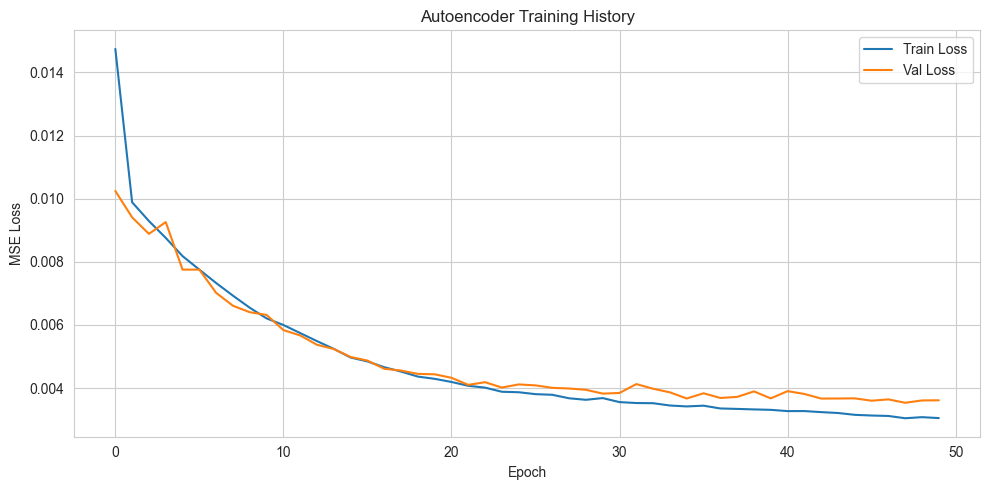

In [34]:
# --- 5. Train Autoencoder with Validation ---
AE_PATH = "upgraded_bottleneck_ae.pth"

if not os.path.exists(AE_PATH):
    print("\n" + "="*80)
    print("  PHASE 0: AUTOENCODER PRE-TRAINING")
    print("="*80)
    
    # Create datasets for AE
    # Create training dataset (calculates normalization stats)
    ae_train_dataset = GTZANDatasetAE(X_train_ae, X_min=X_train_global_min, X_max=X_train_global_max)
    ae_val_dataset = GTZANDatasetAE(X_val_ae, X_min=X_train_global_min, X_max=X_train_global_max)

    print(f"AE normalization - Min: {ae_train_dataset.X_min:.6f}, Max: {ae_train_dataset.X_max:.6f}")
    
    ae_train_loader = DataLoader(ae_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    ae_val_loader = DataLoader(ae_val_dataset, batch_size=BATCH_SIZE)
    
    model_ae = DeepBottleneckAE(latent_dim=LATENT_DIM).to(device)
    criterion_ae = nn.MSELoss()
    optimizer_ae = optim.Adam(model_ae.parameters(), lr=AE_LR)
    
    print(f"\n Training Autoencoder for {AE_EPOCHS} epochs...")
    print(f"   Latent dimension: {LATENT_DIM}")
    
    best_ae_val_loss = float('inf')
    ae_history = {'train_loss': [], 'val_loss': []}
    patience_counter = 0
    
    for epoch in range(AE_EPOCHS):
        # Training
        model_ae.train()
        train_loss = 0.0
        pbar = tqdm(ae_train_loader, desc=f"Epoch {epoch+1}/{AE_EPOCHS} [Train]")
        for inputs in pbar:
            inputs = inputs.to(device)
            optimizer_ae.zero_grad()
            outputs = model_ae(inputs)
            loss = criterion_ae(outputs, inputs)
            loss.backward()
            optimizer_ae.step()
            train_loss += loss.item() * inputs.size(0)
            pbar.set_postfix({'loss': loss.item()})
        
        train_loss /= len(ae_train_loader.dataset)
        ae_history['train_loss'].append(train_loss)
        
        # Validation
        model_ae.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs in ae_val_loader:
                inputs = inputs.to(device)
                outputs = model_ae(inputs)
                loss = criterion_ae(outputs, inputs)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss /= len(ae_val_loader.dataset)
        ae_history['val_loss'].append(val_loss)
        
        print(f"Epoch {epoch+1}/{AE_EPOCHS} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        # Early stopping for AE
        if val_loss < best_ae_val_loss:
            best_ae_val_loss = val_loss
            torch.save(model_ae.state_dict(), AE_PATH)
            patience_counter = 0
            print(f"    New best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= 10:
                print(f"    Early stopping AE training")
                break
    
    # Plot AE training history
    plt.figure(figsize=(10, 5))
    plt.plot(ae_history['train_loss'], label='Train Loss')
    plt.plot(ae_history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Autoencoder Training History')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('ae_training_history.png', dpi=150)
    print(f"\n Autoencoder saved to {AE_PATH}")
    print(f" Training plot saved to ae_training_history.png")
else:
    print(f"\n Loading pre-trained autoencoder from {AE_PATH}")

In [35]:
  # --- 6. Enhanced Classifier with Pre-trained Encoder ---
class EnhancedGenreClassifier(nn.Module):
    """Classifier with deeper head and better regularization"""
    def __init__(self, latent_dim=512, num_genres=10):
        super().__init__()
        
        # Load pre-trained encoder
        base_ae = DeepBottleneckAE(latent_dim)
        base_ae.load_state_dict(torch.load(AE_PATH, map_location=device))
        self.encoder = base_ae.encoder
        
        # Enhanced classifier head with more capacity
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            
            nn.Linear(128, num_genres)
        )
    
    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

In [36]:
# Create datasets for classifier
train_cls_dataset = GTZANDatasetAE(X_train_cls, y_train_cls, X_min=X_train_global_min, X_max=X_train_global_max)
val_cls_dataset = GTZANDatasetAE(X_val, y_val, X_min=X_train_global_min, X_max=X_train_global_max)
test_cls_dataset = GTZANDatasetAE(X_test, y_test, X_min=X_train_global_min, X_max=X_train_global_max)

print(f"Classifier normalization - Min: {train_cls_dataset.X_min:.6f}, Max: {train_cls_dataset.X_max:.6f}")

train_cls_loader = DataLoader(train_cls_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_cls_loader = DataLoader(val_cls_dataset, batch_size=BATCH_SIZE)
test_cls_loader = DataLoader(test_cls_dataset, batch_size=BATCH_SIZE)

model_cls = EnhancedGenreClassifier(latent_dim=LATENT_DIM, num_genres=len(genres)).to(device)
criterion_cls = nn.CrossEntropyLoss()

Classifier normalization - Min: -80.000000, Max: 0.000004


In [37]:
# Helper function to evaluate
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return correct / total, all_preds, all_labels

In [38]:
# --- 7. PHASE 1: Train Classifier Head Only (Encoder Frozen) ---
print("\n" + "="*80)
print("  PHASE 1: TRAINING CLASSIFIER HEAD (ENCODER FROZEN)")
print("="*80)

for param in model_cls.encoder.parameters(): 
    param.requires_grad = False

optimizer_phase1 = optim.Adam(model_cls.classifier.parameters(), lr=PHASE1_LR)
best_val_acc_p1 = 0.0
phase1_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
patience_counter = 0

print(f"\n Training classifier head for {PHASE1_EPOCHS} epochs...")
print(f"   Learning rate: {PHASE1_LR}")
print(f"   Encoder: FROZEN")

for epoch in range(PHASE1_EPOCHS):
    model_cls.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    pbar = tqdm(train_cls_loader, desc=f"Epoch {epoch+1}/{PHASE1_EPOCHS}")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_phase1.zero_grad()
        outputs = model_cls(inputs)
        loss = criterion_cls(outputs, labels)
        loss.backward()
        optimizer_phase1.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pbar.set_postfix({'loss': loss.item(), 'acc': (predicted == labels).sum().item()/labels.size(0)})
    
    train_loss = running_loss / total
    train_acc = correct / total
    val_acc, _, _ = evaluate(model_cls, val_cls_loader)
    
    phase1_history['train_loss'].append(train_loss)
    phase1_history['train_acc'].append(train_acc)
    phase1_history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{PHASE1_EPOCHS} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc_p1:
        best_val_acc_p1 = val_acc
        torch.save(model_cls.state_dict(), "phase1_best.pth")
        patience_counter = 0
        print(f"    New best model! Val Acc: {val_acc:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"    Early stopping Phase 1")
            break

print(f"\n Phase 1 Best Validation Accuracy: {best_val_acc_p1:.4f}")


  PHASE 1: TRAINING CLASSIFIER HEAD (ENCODER FROZEN)

 Training classifier head for 30 epochs...
   Learning rate: 0.001
   Encoder: FROZEN


Epoch 1/30: 100%|██████████| 200/200 [00:01<00:00, 140.85it/s, loss=1.34, acc=0.48] 


Epoch 1/30 - Train Acc: 0.4255, Val Acc: 0.5610
    New best model! Val Acc: 0.5610


Epoch 2/30: 100%|██████████| 200/200 [00:01<00:00, 175.75it/s, loss=1.43, acc=0.56]  


Epoch 2/30 - Train Acc: 0.5706, Val Acc: 0.6348
    New best model! Val Acc: 0.6348


Epoch 3/30: 100%|██████████| 200/200 [00:01<00:00, 170.16it/s, loss=1.04, acc=0.6]   


Epoch 3/30 - Train Acc: 0.6025, Val Acc: 0.6492
    New best model! Val Acc: 0.6492


Epoch 4/30: 100%|██████████| 200/200 [00:01<00:00, 173.91it/s, loss=1.15, acc=0.48]  


Epoch 4/30 - Train Acc: 0.6337, Val Acc: 0.6385


Epoch 5/30: 100%|██████████| 200/200 [00:01<00:00, 172.86it/s, loss=1.05, acc=0.64]  


Epoch 5/30 - Train Acc: 0.6424, Val Acc: 0.6567
    New best model! Val Acc: 0.6567


Epoch 6/30: 100%|██████████| 200/200 [00:01<00:00, 170.07it/s, loss=1.04, acc=0.56]  


Epoch 6/30 - Train Acc: 0.6540, Val Acc: 0.6554


Epoch 7/30: 100%|██████████| 200/200 [00:01<00:00, 175.90it/s, loss=0.99, acc=0.64]  


Epoch 7/30 - Train Acc: 0.6596, Val Acc: 0.6604
    New best model! Val Acc: 0.6604


Epoch 8/30: 100%|██████████| 200/200 [00:01<00:00, 173.16it/s, loss=1.15, acc=0.64]  


Epoch 8/30 - Train Acc: 0.6584, Val Acc: 0.6592


Epoch 9/30: 100%|██████████| 200/200 [00:01<00:00, 178.64it/s, loss=0.852, acc=0.72] 


Epoch 9/30 - Train Acc: 0.6704, Val Acc: 0.6692
    New best model! Val Acc: 0.6692


Epoch 10/30: 100%|██████████| 200/200 [00:01<00:00, 179.21it/s, loss=1.1, acc=0.52]   


Epoch 10/30 - Train Acc: 0.6786, Val Acc: 0.6673


Epoch 11/30: 100%|██████████| 200/200 [00:01<00:00, 173.61it/s, loss=0.984, acc=0.56] 


Epoch 11/30 - Train Acc: 0.6767, Val Acc: 0.6760
    New best model! Val Acc: 0.6760


Epoch 12/30: 100%|██████████| 200/200 [00:01<00:00, 179.05it/s, loss=0.546, acc=0.76] 


Epoch 12/30 - Train Acc: 0.6829, Val Acc: 0.6817
    New best model! Val Acc: 0.6817


Epoch 13/30: 100%|██████████| 200/200 [00:01<00:00, 179.37it/s, loss=0.776, acc=0.68] 


Epoch 13/30 - Train Acc: 0.6832, Val Acc: 0.6642


Epoch 14/30: 100%|██████████| 200/200 [00:01<00:00, 173.16it/s, loss=0.738, acc=0.76] 


Epoch 14/30 - Train Acc: 0.6887, Val Acc: 0.6792


Epoch 15/30: 100%|██████████| 200/200 [00:01<00:00, 179.37it/s, loss=1.03, acc=0.64]  


Epoch 15/30 - Train Acc: 0.6923, Val Acc: 0.6892
    New best model! Val Acc: 0.6892


Epoch 16/30: 100%|██████████| 200/200 [00:01<00:00, 172.86it/s, loss=1.13, acc=0.44]  


Epoch 16/30 - Train Acc: 0.6904, Val Acc: 0.6854


Epoch 17/30: 100%|██████████| 200/200 [00:01<00:00, 179.70it/s, loss=0.911, acc=0.6]  


Epoch 17/30 - Train Acc: 0.6947, Val Acc: 0.6898
    New best model! Val Acc: 0.6898


Epoch 18/30: 100%|██████████| 200/200 [00:01<00:00, 176.83it/s, loss=0.574, acc=0.76] 


Epoch 18/30 - Train Acc: 0.6992, Val Acc: 0.6992
    New best model! Val Acc: 0.6992


Epoch 19/30: 100%|██████████| 200/200 [00:01<00:00, 164.88it/s, loss=1.24, acc=0.56]  


Epoch 19/30 - Train Acc: 0.7041, Val Acc: 0.6842


Epoch 20/30: 100%|██████████| 200/200 [00:01<00:00, 176.68it/s, loss=0.918, acc=0.6]  


Epoch 20/30 - Train Acc: 0.7119, Val Acc: 0.6961


Epoch 21/30: 100%|██████████| 200/200 [00:01<00:00, 167.22it/s, loss=1.04, acc=0.72]  


Epoch 21/30 - Train Acc: 0.7058, Val Acc: 0.6954


Epoch 22/30: 100%|██████████| 200/200 [00:01<00:00, 177.62it/s, loss=1.09, acc=0.64]  


Epoch 22/30 - Train Acc: 0.7000, Val Acc: 0.6986


Epoch 23/30: 100%|██████████| 200/200 [00:01<00:00, 172.71it/s, loss=0.587, acc=0.8]  


Epoch 23/30 - Train Acc: 0.7062, Val Acc: 0.6923


Epoch 24/30: 100%|██████████| 200/200 [00:01<00:00, 171.82it/s, loss=0.859, acc=0.6]  


Epoch 24/30 - Train Acc: 0.7041, Val Acc: 0.7004
    New best model! Val Acc: 0.7004


Epoch 25/30: 100%|██████████| 200/200 [00:01<00:00, 178.25it/s, loss=0.799, acc=0.68] 


Epoch 25/30 - Train Acc: 0.7044, Val Acc: 0.6979


Epoch 26/30: 100%|██████████| 200/200 [00:01<00:00, 179.53it/s, loss=1.18, acc=0.6]   


Epoch 26/30 - Train Acc: 0.7081, Val Acc: 0.7011
    New best model! Val Acc: 0.7011


Epoch 27/30: 100%|██████████| 200/200 [00:01<00:00, 173.61it/s, loss=0.82, acc=0.68]  


Epoch 27/30 - Train Acc: 0.7089, Val Acc: 0.6992


Epoch 28/30: 100%|██████████| 200/200 [00:01<00:00, 179.37it/s, loss=0.817, acc=0.72] 


Epoch 28/30 - Train Acc: 0.6969, Val Acc: 0.6879


Epoch 29/30: 100%|██████████| 200/200 [00:01<00:00, 174.22it/s, loss=0.698, acc=0.72] 


Epoch 29/30 - Train Acc: 0.7092, Val Acc: 0.6898


Epoch 30/30: 100%|██████████| 200/200 [00:01<00:00, 181.16it/s, loss=0.919, acc=0.68] 


Epoch 30/30 - Train Acc: 0.7030, Val Acc: 0.6804

 Phase 1 Best Validation Accuracy: 0.7011


In [39]:
# --- 8. PHASE 2: Fine-tune Entire Model ---
print("\n" + "="*80)
print("  PHASE 2: FULL MODEL FINE-TUNING")
print("="*80)

model_cls.load_state_dict(torch.load("phase1_best.pth"))

# Unfreeze all parameters
for param in model_cls.parameters(): 
    param.requires_grad = True

optimizer_phase2 = optim.Adam(model_cls.parameters(), lr=PHASE2_LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_phase2, mode='max', factor=0.5, patience=5
)

best_val_acc_p2 = 0.0
phase2_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
patience_counter = 0

print(f"\n Fine-tuning full model for {PHASE2_EPOCHS} epochs...")
print(f"   Learning rate: {PHASE2_LR}")
print(f"   Encoder: UNFROZEN")

for epoch in range(PHASE2_EPOCHS):
    model_cls.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    pbar = tqdm(train_cls_loader, desc=f"Epoch {epoch+1}/{PHASE2_EPOCHS}")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_phase2.zero_grad()
        outputs = model_cls(inputs)
        loss = criterion_cls(outputs, labels)
        loss.backward()
        optimizer_phase2.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pbar.set_postfix({'loss': loss.item(), 'acc': (predicted == labels).sum().item()/labels.size(0)})
    
    train_loss = running_loss / total
    train_acc = correct / total
    val_acc, _, _ = evaluate(model_cls, val_cls_loader)
    
    phase2_history['train_loss'].append(train_loss)
    phase2_history['train_acc'].append(train_acc)
    phase2_history['val_acc'].append(val_acc)
    
    scheduler.step(val_acc)
    
    print(f"Epoch {epoch+1}/{PHASE2_EPOCHS} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc_p2:
        best_val_acc_p2 = val_acc
        torch.save(model_cls.state_dict(), "best_finetuned_model.pth")
        patience_counter = 0
        print(f"    New best model! Val Acc: {val_acc:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"    Early stopping Phase 2")
            break

print(f"\nPhase 2 Best Validation Accuracy: {best_val_acc_p2:.4f}")


  PHASE 2: FULL MODEL FINE-TUNING

 Fine-tuning full model for 50 epochs...
   Learning rate: 5e-05
   Encoder: UNFROZEN


Epoch 1/50: 100%|██████████| 200/200 [00:03<00:00, 66.37it/s, loss=0.597, acc=0.84] 


Epoch 1/50 - Train Acc: 0.7299, Val Acc: 0.7167
    New best model! Val Acc: 0.7167


Epoch 2/50: 100%|██████████| 200/200 [00:03<00:00, 66.51it/s, loss=0.504, acc=0.92] 


Epoch 2/50 - Train Acc: 0.7499, Val Acc: 0.7261
    New best model! Val Acc: 0.7261


Epoch 3/50: 100%|██████████| 200/200 [00:03<00:00, 66.23it/s, loss=0.583, acc=0.76] 


Epoch 3/50 - Train Acc: 0.7640, Val Acc: 0.7292
    New best model! Val Acc: 0.7292


Epoch 4/50: 100%|██████████| 200/200 [00:02<00:00, 66.73it/s, loss=0.694, acc=0.76] 


Epoch 4/50 - Train Acc: 0.7662, Val Acc: 0.7380
    New best model! Val Acc: 0.7380


Epoch 5/50: 100%|██████████| 200/200 [00:03<00:00, 66.45it/s, loss=0.483, acc=0.88] 


Epoch 5/50 - Train Acc: 0.7860, Val Acc: 0.7398
    New best model! Val Acc: 0.7398


Epoch 6/50: 100%|██████████| 200/200 [00:02<00:00, 67.09it/s, loss=0.509, acc=0.84] 


Epoch 6/50 - Train Acc: 0.7982, Val Acc: 0.7467
    New best model! Val Acc: 0.7467


Epoch 7/50: 100%|██████████| 200/200 [00:03<00:00, 66.16it/s, loss=0.615, acc=0.76] 


Epoch 7/50 - Train Acc: 0.7951, Val Acc: 0.7517
    New best model! Val Acc: 0.7517


Epoch 8/50: 100%|██████████| 200/200 [00:03<00:00, 66.53it/s, loss=0.511, acc=0.8]  


Epoch 8/50 - Train Acc: 0.8103, Val Acc: 0.7517


Epoch 9/50: 100%|██████████| 200/200 [00:02<00:00, 67.07it/s, loss=0.451, acc=0.88] 


Epoch 9/50 - Train Acc: 0.8214, Val Acc: 0.7480


Epoch 10/50: 100%|██████████| 200/200 [00:02<00:00, 66.68it/s, loss=0.55, acc=0.72]  


Epoch 10/50 - Train Acc: 0.8351, Val Acc: 0.7586
    New best model! Val Acc: 0.7586


Epoch 11/50: 100%|██████████| 200/200 [00:03<00:00, 66.40it/s, loss=0.363, acc=0.8]  


Epoch 11/50 - Train Acc: 0.8483, Val Acc: 0.7711
    New best model! Val Acc: 0.7711


Epoch 12/50: 100%|██████████| 200/200 [00:03<00:00, 66.05it/s, loss=0.411, acc=0.76] 


Epoch 12/50 - Train Acc: 0.8484, Val Acc: 0.7649


Epoch 13/50: 100%|██████████| 200/200 [00:03<00:00, 63.25it/s, loss=0.516, acc=0.8]  


Epoch 13/50 - Train Acc: 0.8684, Val Acc: 0.7674


Epoch 14/50: 100%|██████████| 200/200 [00:03<00:00, 64.73it/s, loss=0.287, acc=0.84] 


Epoch 14/50 - Train Acc: 0.8686, Val Acc: 0.7742
    New best model! Val Acc: 0.7742


Epoch 15/50: 100%|██████████| 200/200 [00:03<00:00, 65.19it/s, loss=0.455, acc=0.88] 


Epoch 15/50 - Train Acc: 0.8864, Val Acc: 0.7749
    New best model! Val Acc: 0.7749


Epoch 16/50: 100%|██████████| 200/200 [00:03<00:00, 65.63it/s, loss=0.363, acc=0.88] 


Epoch 16/50 - Train Acc: 0.8860, Val Acc: 0.7805
    New best model! Val Acc: 0.7805


Epoch 17/50: 100%|██████████| 200/200 [00:03<00:00, 65.21it/s, loss=0.241, acc=0.96] 


Epoch 17/50 - Train Acc: 0.8968, Val Acc: 0.7755


Epoch 18/50: 100%|██████████| 200/200 [00:03<00:00, 64.96it/s, loss=0.502, acc=0.8]  


Epoch 18/50 - Train Acc: 0.9043, Val Acc: 0.7811
    New best model! Val Acc: 0.7811


Epoch 19/50: 100%|██████████| 200/200 [00:03<00:00, 65.04it/s, loss=0.193, acc=0.96] 


Epoch 19/50 - Train Acc: 0.9058, Val Acc: 0.7824
    New best model! Val Acc: 0.7824


Epoch 20/50: 100%|██████████| 200/200 [00:03<00:00, 64.96it/s, loss=0.148, acc=1]    


Epoch 20/50 - Train Acc: 0.9173, Val Acc: 0.7817


Epoch 21/50: 100%|██████████| 200/200 [00:03<00:00, 64.87it/s, loss=0.432, acc=0.84] 


Epoch 21/50 - Train Acc: 0.9243, Val Acc: 0.7805


Epoch 22/50: 100%|██████████| 200/200 [00:03<00:00, 65.45it/s, loss=0.199, acc=0.92] 


Epoch 22/50 - Train Acc: 0.9270, Val Acc: 0.7936
    New best model! Val Acc: 0.7936


Epoch 23/50: 100%|██████████| 200/200 [00:03<00:00, 65.82it/s, loss=0.465, acc=0.88] 


Epoch 23/50 - Train Acc: 0.9345, Val Acc: 0.7880


Epoch 24/50: 100%|██████████| 200/200 [00:03<00:00, 65.19it/s, loss=0.224, acc=0.88]  


Epoch 24/50 - Train Acc: 0.9427, Val Acc: 0.7805


Epoch 25/50: 100%|██████████| 200/200 [00:03<00:00, 64.94it/s, loss=0.204, acc=0.92]  


Epoch 25/50 - Train Acc: 0.9465, Val Acc: 0.7880


Epoch 26/50: 100%|██████████| 200/200 [00:03<00:00, 64.90it/s, loss=0.102, acc=1]     


Epoch 26/50 - Train Acc: 0.9476, Val Acc: 0.7892


Epoch 27/50: 100%|██████████| 200/200 [00:03<00:00, 65.13it/s, loss=0.146, acc=0.92]  


Epoch 27/50 - Train Acc: 0.9521, Val Acc: 0.7824


Epoch 28/50: 100%|██████████| 200/200 [00:03<00:00, 64.76it/s, loss=0.139, acc=1]     


Epoch 28/50 - Train Acc: 0.9575, Val Acc: 0.7867


Epoch 29/50: 100%|██████████| 200/200 [00:03<00:00, 65.75it/s, loss=0.0591, acc=1]    


Epoch 29/50 - Train Acc: 0.9629, Val Acc: 0.7861


Epoch 30/50: 100%|██████████| 200/200 [00:03<00:00, 64.67it/s, loss=0.242, acc=0.88]  


Epoch 30/50 - Train Acc: 0.9631, Val Acc: 0.7861


Epoch 31/50: 100%|██████████| 200/200 [00:03<00:00, 64.55it/s, loss=0.185, acc=0.92]  


Epoch 31/50 - Train Acc: 0.9684, Val Acc: 0.7842


Epoch 32/50: 100%|██████████| 200/200 [00:03<00:00, 64.56it/s, loss=0.105, acc=1]     


Epoch 32/50 - Train Acc: 0.9667, Val Acc: 0.7861


Epoch 33/50: 100%|██████████| 200/200 [00:03<00:00, 64.92it/s, loss=0.164, acc=0.96]  


Epoch 33/50 - Train Acc: 0.9698, Val Acc: 0.7880


Epoch 34/50: 100%|██████████| 200/200 [00:03<00:00, 65.15it/s, loss=0.12, acc=0.96]   


Epoch 34/50 - Train Acc: 0.9753, Val Acc: 0.7861


Epoch 35/50: 100%|██████████| 200/200 [00:03<00:00, 64.66it/s, loss=0.0913, acc=0.96] 


Epoch 35/50 - Train Acc: 0.9729, Val Acc: 0.7849


Epoch 36/50: 100%|██████████| 200/200 [00:03<00:00, 65.70it/s, loss=0.087, acc=1]     


Epoch 36/50 - Train Acc: 0.9720, Val Acc: 0.7849


Epoch 37/50: 100%|██████████| 200/200 [00:03<00:00, 64.80it/s, loss=0.112, acc=1]     


Epoch 37/50 - Train Acc: 0.9751, Val Acc: 0.7805
    Early stopping Phase 2

Phase 2 Best Validation Accuracy: 0.7936


In [40]:
# --- 9. Final Evaluation ---
print("\n" + "="*80)
print("  FINAL EVALUATION ON TEST SET")
print("="*80)

model_cls.load_state_dict(torch.load("best_finetuned_model.pth"))
test_acc, all_preds, all_labels = evaluate(model_cls, test_cls_loader)

print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=genres))


  FINAL EVALUATION ON TEST SET

Final Test Accuracy: 0.7633

--- Classification Report ---
              precision    recall  f1-score   support

       blues       0.79      0.77      0.78       200
   classical       0.89      0.92      0.90       200
     country       0.73      0.72      0.72       200
       disco       0.65      0.72      0.68       200
      hiphop       0.74      0.73      0.74       200
        jazz       0.73      0.80      0.76       198
       metal       0.89      0.93      0.91       200
         pop       0.78      0.77      0.77       200
      reggae       0.72      0.66      0.68       200
        rock       0.72      0.62      0.66       200

    accuracy                           0.76      1998
   macro avg       0.76      0.76      0.76      1998
weighted avg       0.76      0.76      0.76      1998



In [41]:
# --- 11. Save Results Summary ---
results_summary = {
    'model': 'Upgraded AE + Classifier',
    'latent_dim': LATENT_DIM,
    'phase1_best_val_acc': float(best_val_acc_p1),
    'phase2_best_val_acc': float(best_val_acc_p2),
    'final_test_acc': float(test_acc),
    'hyperparameters': {
        'ae_epochs': AE_EPOCHS,
        'ae_lr': AE_LR,
        'phase1_epochs': PHASE1_EPOCHS,
        'phase1_lr': PHASE1_LR,
        'phase2_epochs': PHASE2_EPOCHS,
        'phase2_lr': PHASE2_LR,
        'batch_size': BATCH_SIZE,
        'patience': PATIENCE
    }
}

import json
with open('results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\n" + "="*80)
print("  PIPELINE COMPLETE!")
print("="*80)
print(f"\nResults Summary:")
print(f"   Phase 1 (Frozen) Val Acc:   {best_val_acc_p1:.4f}")
print(f"   Phase 2 (Fine-tuned) Val Acc: {best_val_acc_p2:.4f}")
print(f"   Final Test Accuracy:         {test_acc:.4f}")
print("="*80)


  PIPELINE COMPLETE!

Results Summary:
   Phase 1 (Frozen) Val Acc:   0.7011
   Phase 2 (Fine-tuned) Val Acc: 0.7936
   Final Test Accuracy:         0.7633



Generating visualizations...
Saved: training_history_combined.png
Saved: confusion_matrix_upgraded.png

Generating t-SNE visualization of latent space...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1998 samples in 0.003s...
[t-SNE] Computed neighbors for 1998 samples in 0.118s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1998
[t-SNE] Computed conditional probabilities for sample 1998 / 1998
[t-SNE] Mean sigma: 146.533062
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.097351
[t-SNE] KL divergence after 1000 iterations: 1.840515
Saved: tsne_latent_space_upgraded.png


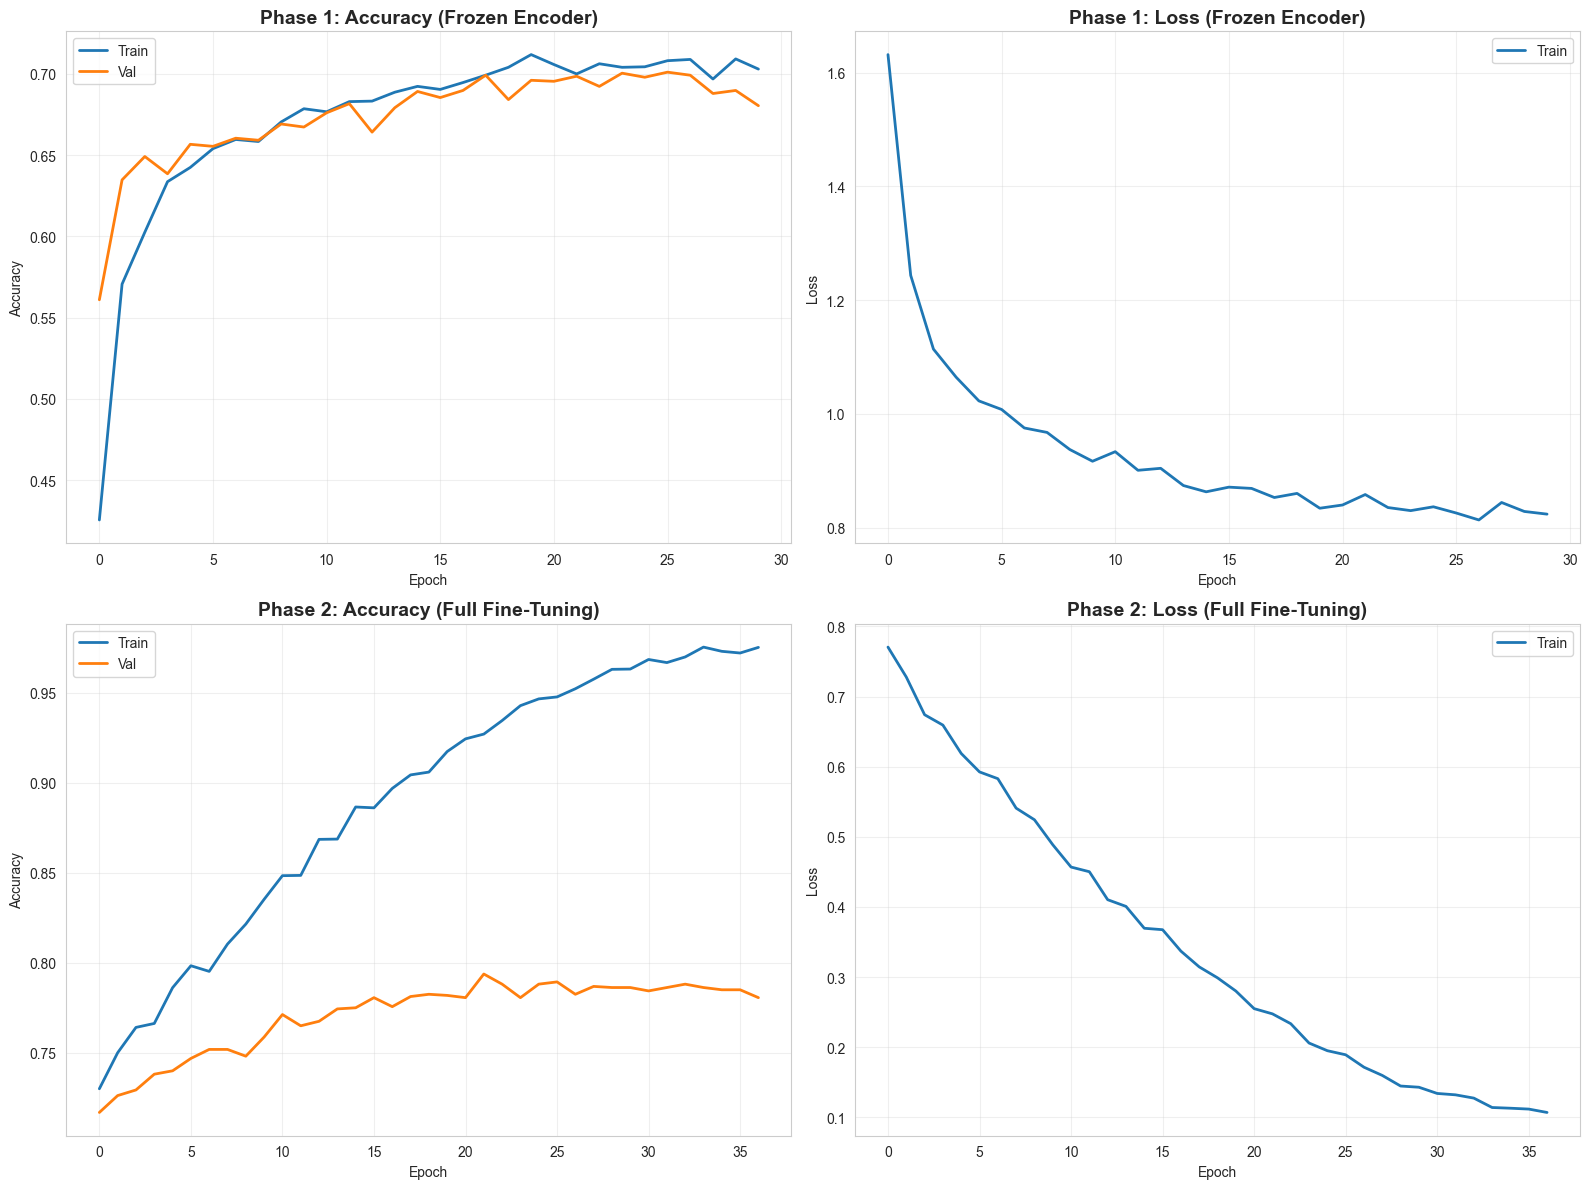

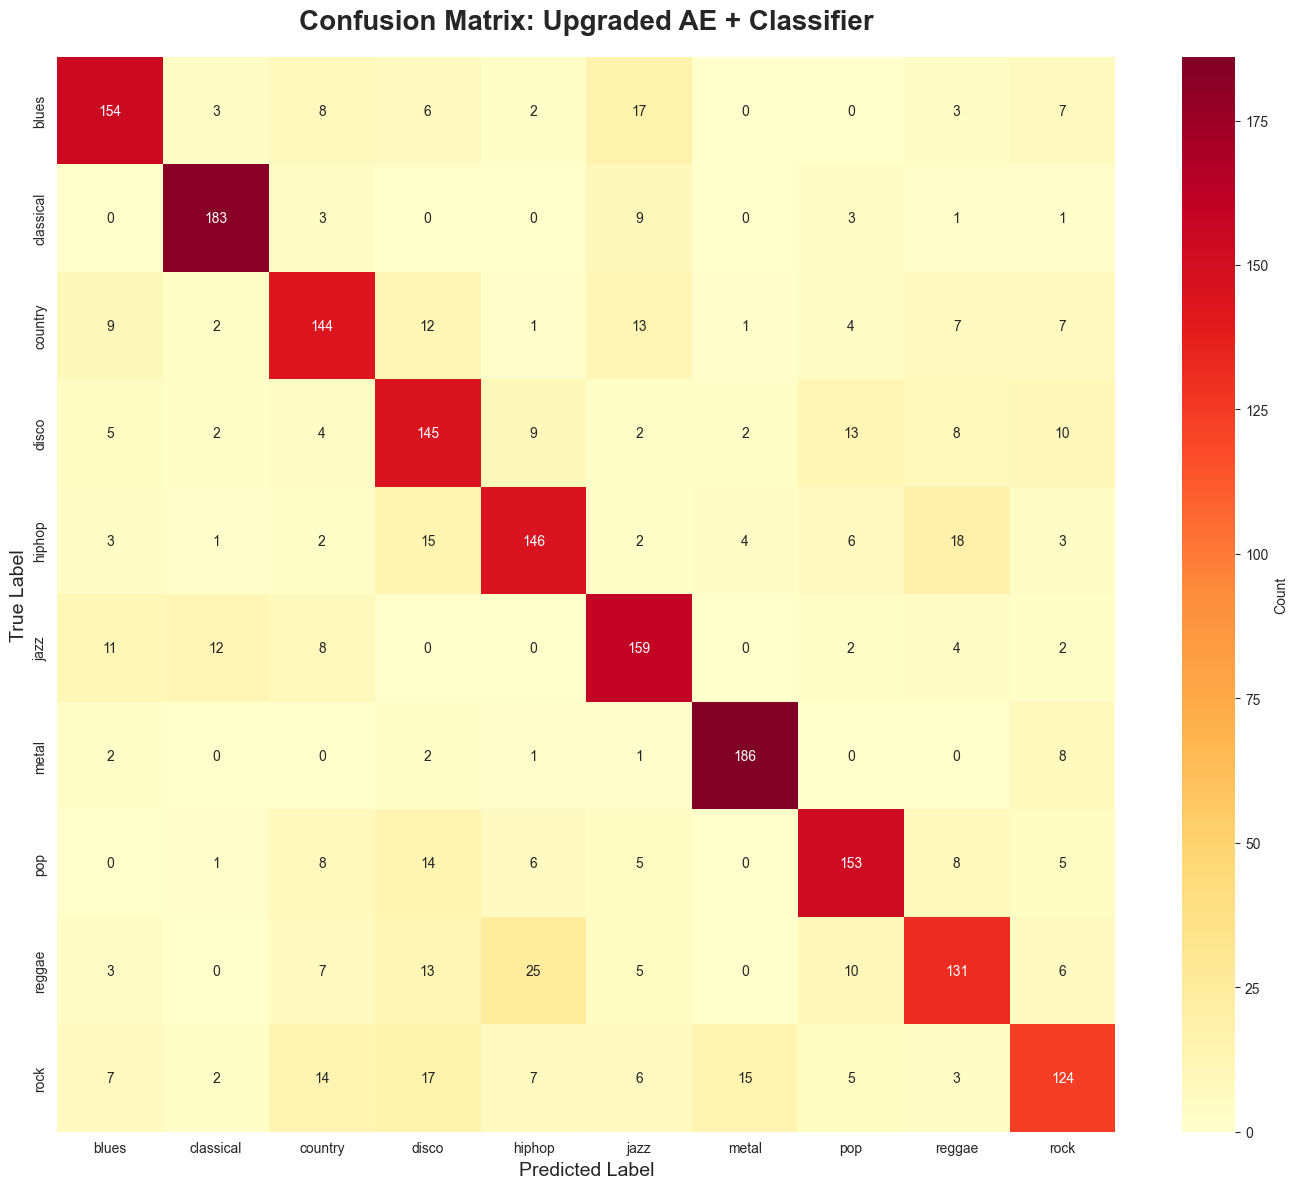

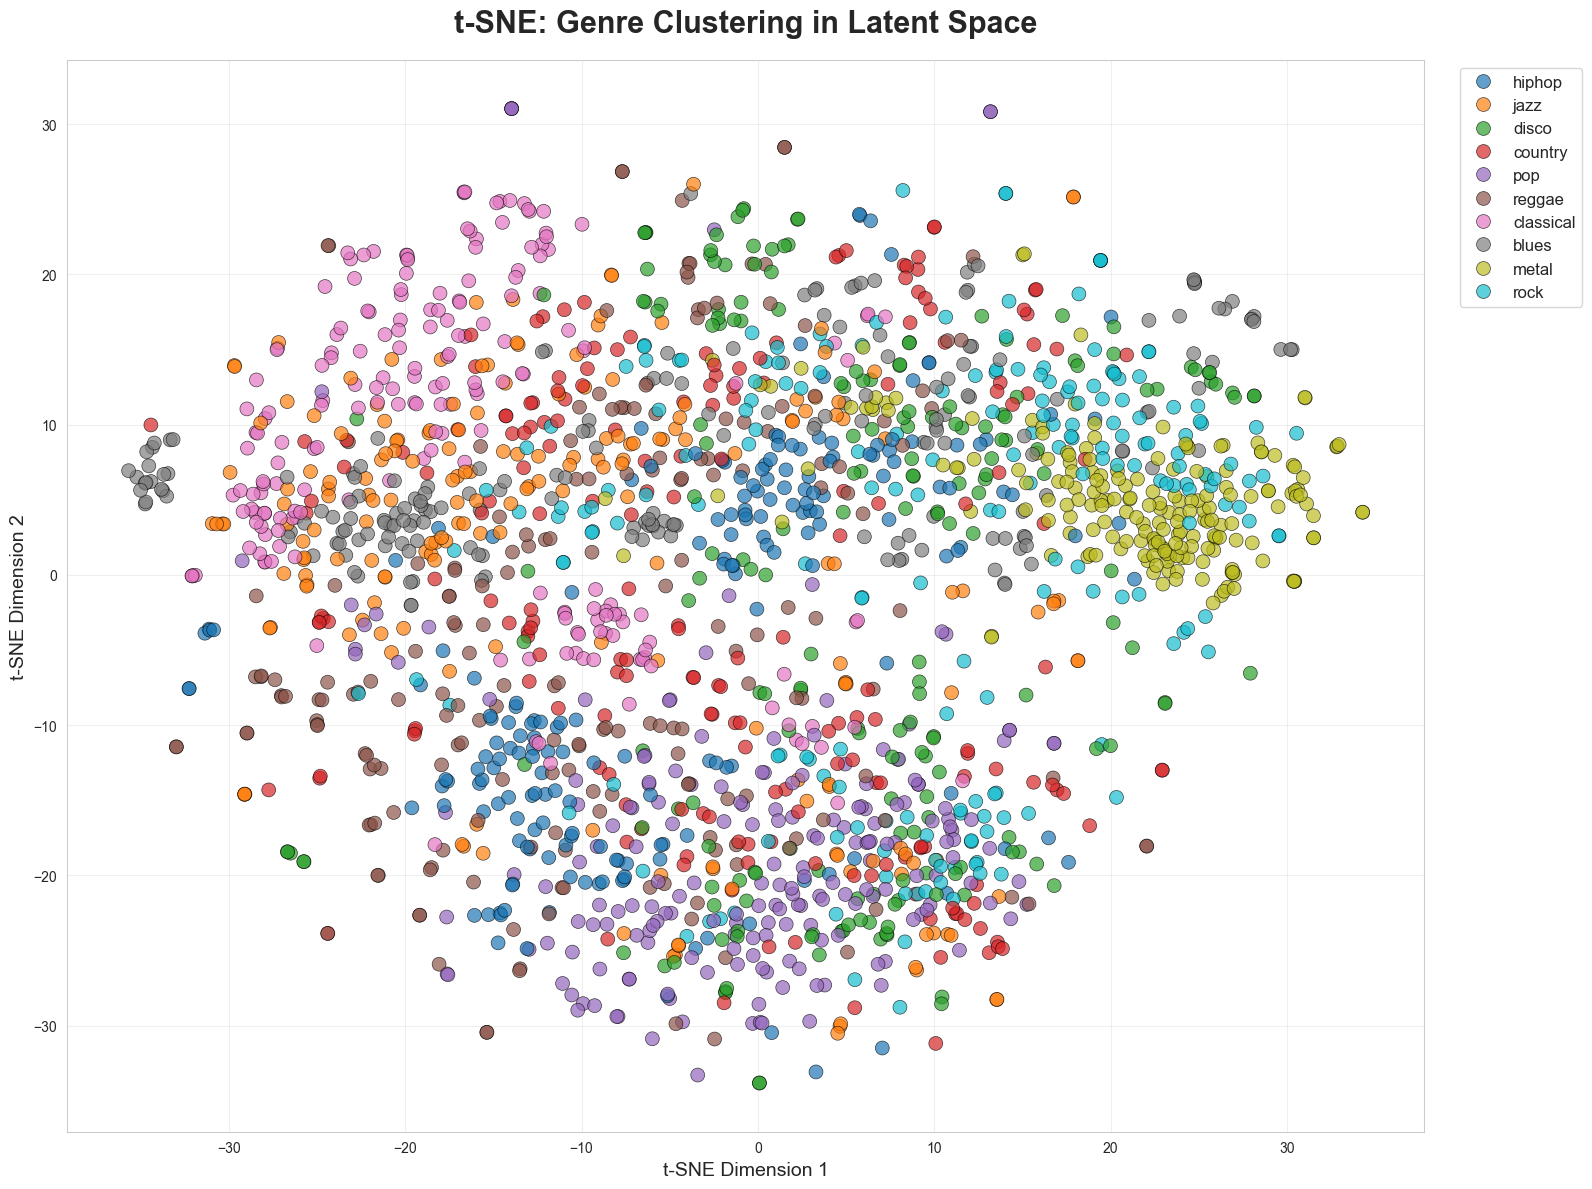

In [42]:
# --- 10. Visualizations ---
print("\nGenerating visualizations...")

# Combined training history
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Phase 1
axes[0, 0].plot(phase1_history['train_acc'], label='Train', linewidth=2)
axes[0, 0].plot(phase1_history['val_acc'], label='Val', linewidth=2)
axes[0, 0].set_title('Phase 1: Accuracy (Frozen Encoder)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(phase1_history['train_loss'], label='Train', linewidth=2)
axes[0, 1].set_title('Phase 1: Loss (Frozen Encoder)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Phase 2
axes[1, 0].plot(phase2_history['train_acc'], label='Train', linewidth=2)
axes[1, 0].plot(phase2_history['val_acc'], label='Val', linewidth=2)
axes[1, 0].set_title('Phase 2: Accuracy (Full Fine-Tuning)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(phase2_history['train_loss'], label='Train', linewidth=2)
axes[1, 1].set_title('Phase 2: Loss (Full Fine-Tuning)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_combined.png', dpi=150, bbox_inches='tight')
print("Saved: training_history_combined.png")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=genres, yticklabels=genres, 
            cmap='YlOrRd', cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix: Upgraded AE + Classifier', fontsize=20, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix_upgraded.png', dpi=150, bbox_inches='tight')
print("Saved: confusion_matrix_upgraded.png")

# t-SNE Visualization
print("\nGenerating t-SNE visualization of latent space...")
model_cls.eval()
tsne_loader = DataLoader(test_cls_dataset, batch_size=len(test_cls_dataset))
features, labels = next(iter(tsne_loader))

with torch.no_grad(): 
    latent_features = model_cls.encoder(features.to(device)).cpu().numpy()

tsne = TSNE(n_components=2, perplexity=40, random_state=42, init='pca', 
            learning_rate='auto', max_iter=1000, verbose=1)
tsne_results = tsne.fit_transform(latent_features)

df_tsne = pd.DataFrame({
    'tsne-1': tsne_results[:,0], 
    'tsne-2': tsne_results[:,1], 
    'genre': [genres[i] for i in labels.numpy()]
})

plt.figure(figsize=(16, 12))
sns.scatterplot(x="tsne-1", y="tsne-2", hue="genre", 
                palette=sns.color_palette("tab10", 10), 
                data=df_tsne, s=100, alpha=0.7, edgecolor='black', linewidth=0.5)
plt.title('t-SNE: Genre Clustering in Latent Space', 
          fontsize=22, fontweight='bold', pad=20)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('tsne_latent_space_upgraded.png', dpi=150, bbox_inches='tight')
print("Saved: tsne_latent_space_upgraded.png")